# SWEX Curriculum Survey Analysis

This project analyses survey data from the SWEX Curriculum for engineering archetypes. The analysis is performed using Python and Jupyter Notebooks.

Clean up the survey data and remove columns we do not need

In [1]:
import pandas as pd

df = pd.read_excel("2025-03 Core Software Engineer Archetype Survey Results.xlsx", engine="openpyxl")

df = df.loc[:, ~df.columns.str.contains("Any comments on the above topics you would like to discuss?", case=False)]

df.columns = df.columns.str.replace(r"\[submitted as .*?\]", "", regex=True)

df = df.iloc[:, 6:] # Remove the first few columns

Count all votes for all the competencies in the Dreyfuss model

In [2]:
novice_counts = (df == "Novice").sum()
advanced_beginner_counts = (df == "Advanced Beginner").sum()
competent_counts = (df == "Competent").sum()
proficient_counts = (df == "Proficient").sum()
expert_counts = (df == "Expert").sum()
remove_counts = (df == "Not a Core SE archetype topic").sum()
unclear_counts = (df == "Unclear").sum()

overview = pd.DataFrame({
    'Novice': novice_counts,
    'Advanced Beginner': advanced_beginner_counts,
    'Competent': competent_counts,
    'Proficient': proficient_counts,
    'Expert': expert_counts,
    'Remove': remove_counts,
    'Unclear': unclear_counts
}).reset_index()

display(overview)

index  Novice  Advanced Beginner  \
0                    Developer Tooling   basics       58                 10   
1                 Primary Programming   Language      55                 11   
2                              The Test Pyramind      20                 45   
3      Prompt Engineering   Skills for Engineers      15                 30   
4                                OS Shell basics      29                 34   
..                                           ...     ...                ...   
65                       Version Control Systems      41                 24   
66                    Containers & Orchestration       4                 39   
67                              Cloud Computing        5                 15   
68                            Chaos Engineering        8                  4   
69  Site Reliability Engineering for Developers        4                  8   

    Competent  Proficient  Expert  Remove  Unclear  
0          10           7       0       1        2  
1           8           6       6       1        1  
2          16           5       0       1        1  
3          20           5       0      10        8  
4          15           0       0       8        2  
..        ...         ...     ...     ...      ...  
65         12           5       4       0        2  
66         33          10       0       1        1  
67         57           6       0       3        2  
68          2          41      16      10        7  
69          4           9      49      10        4  

[70 rows x 8 columns]

Find the competency level with the most votes

In [3]:
overview['Max Level'] = overview.iloc[:, 1:].idxmax(axis=1)

In [4]:
display(overview.iloc[:, [0, -1]])

index          Max Level
0                    Developer Tooling   basics              Novice
1                 Primary Programming   Language             Novice
2                              The Test Pyramind  Advanced Beginner
3      Prompt Engineering   Skills for Engineers  Advanced Beginner
4                                OS Shell basics  Advanced Beginner
..                                           ...                ...
65                       Version Control Systems             Novice
66                    Containers & Orchestration  Advanced Beginner
67                              Cloud Computing           Competent
68                            Chaos Engineering          Proficient
69  Site Reliability Engineering for Developers              Expert

[70 rows x 2 columns]

Use a 10% threshold to determine whether a particular topic needs further discussion

In [5]:
number_of_responses = len(df)
discussion_threshold = int(number_of_responses * (10 / 100))
print(f"The 10% discussion threshold for {number_of_responses} responses is {discussion_threshold}.")

The 10% discussion threshold for 88 responses is 8.


In [6]:
overview['Is Unclear'] = overview['Unclear'] >= discussion_threshold
overview['Is Remove'] = overview['Remove'] >= discussion_threshold


See if a majority of 50% was reached for a topic

In [7]:
half_votes = number_of_responses / 2

competency_cols = ['Novice', 'Advanced Beginner', 'Competent', 'Proficient', 'Expert']
overview['Is Agreement'] = overview[competency_cols].ge(half_votes).any(axis=1)

In [8]:
display(overview.iloc[:, [0, -1, -2, -3]])

index  Is Agreement  Is Remove  \
0                    Developer Tooling   basics           True      False   
1                 Primary Programming   Language          True      False   
2                              The Test Pyramind          True      False   
3      Prompt Engineering   Skills for Engineers         False       True   
4                                OS Shell basics         False       True   
..                                           ...           ...        ...   
65                       Version Control Systems         False      False   
66                    Containers & Orchestration         False      False   
67                              Cloud Computing           True      False   
68                            Chaos Engineering          False       True   
69  Site Reliability Engineering for Developers           True       True   

    Is Unclear  
0        False  
1        False  
2        False  
3         True  
4        False  
..         ...  
65       False  
66       False  
67       False  
68       False  
69       False  

[70 rows x 4 columns]

We have reached an agreement once it is not unclear nor marked for removal

In [9]:
overview['Agreement'] = overview['Is Agreement'] & ~overview['Is Unclear'] & ~overview['Is Remove']

In [10]:
quick_summary = overview.iloc[:, [0, -1]]
display(quick_summary)
quick_summary['Agreement'].value_counts()

index  Agreement
0                    Developer Tooling   basics        True
1                 Primary Programming   Language       True
2                              The Test Pyramind       True
3      Prompt Engineering   Skills for Engineers      False
4                                OS Shell basics      False
..                                           ...        ...
65                       Version Control Systems      False
66                    Containers & Orchestration      False
67                              Cloud Computing        True
68                            Chaos Engineering       False
69  Site Reliability Engineering for Developers       False

[70 rows x 2 columns]

Agreement
False    48
True     22
Name: count, dtype: int64

Save the analysis to an excel spreadsheet

In [11]:
overview.to_excel('output_file.xlsx', index=False)

## Number of Topics per Competency Level

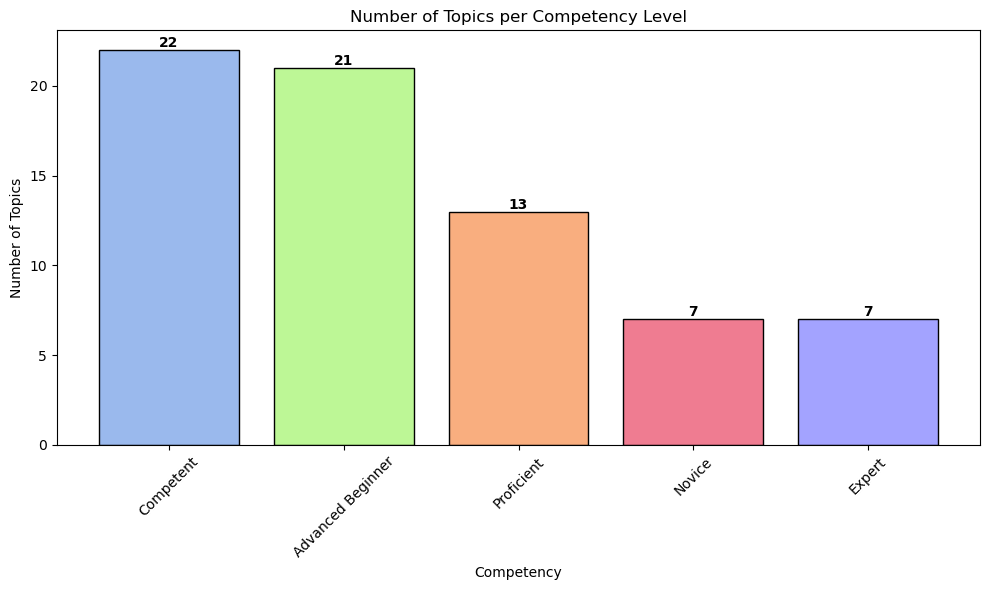

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

color_palette = ['#9ab9ed', '#bdf796', '#f9ae7f', '#ef7c91', '#a3a3ff', '#c89ff4', '#fffcbf']

# Count how many topics fall into each 'Max Level'
max_level_counts = overview['Max Level'].value_counts()

plt.figure(figsize=(10, 6))

plt.bar(
    max_level_counts.index, 
    max_level_counts.values, 
    color=color_palette, 
    edgecolor='black')

plt.title('Number of Topics per Competency Level')
plt.xlabel('Competency')
plt.ylabel('Number of Topics')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the counts on top of each bar
for i, count in enumerate(max_level_counts.values):
    plt.text(
        i, 
        count,
        str(count), 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )

# Show the plot
plt.tight_layout()
plt.show()

## Distribution of Topics by Outcome

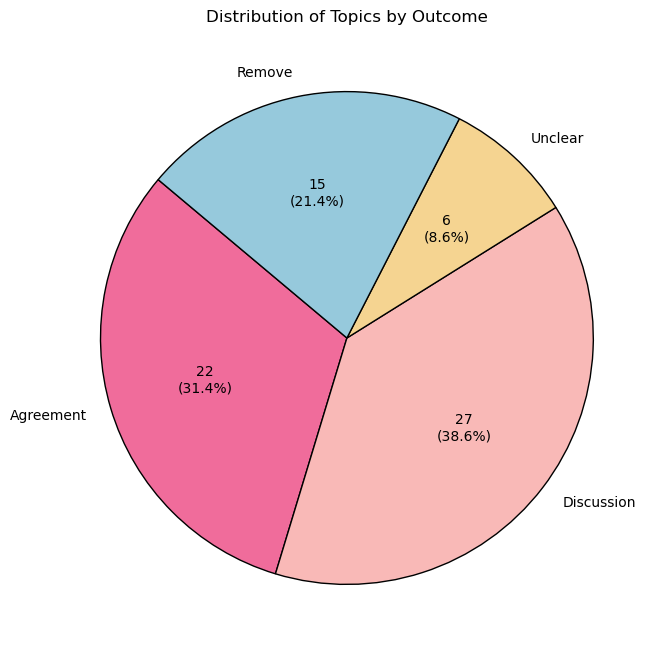

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Custom function to show both absolute value and percentage
def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f"{absolute}\n({pct:.1f}%)"
    
agreement_count = overview['Agreement'].sum()
unclear_count = overview['Is Unclear'].sum()
remove_count = overview['Is Remove'].sum()
disagreement_count = (~overview['Agreement']).sum() - remove_count - unclear_count

status_counts = {
    'Agreement': agreement_count,
    'Discussion': disagreement_count,
    'Unclear': unclear_count,
    'Remove': remove_count
}

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    status_counts.values(), 
    labels=status_counts.keys(), 
    autopct=lambda pct: func(pct, status_counts.values()), 
    startangle=140, 
    colors=['#F06C9B', '#F9B9B7', '#F5D491', '#96C9DC'], 
    wedgeprops={'edgecolor': 'black'})

plt.title('Distribution of Topics by Outcome')

plt.show()

## SWEX Participation

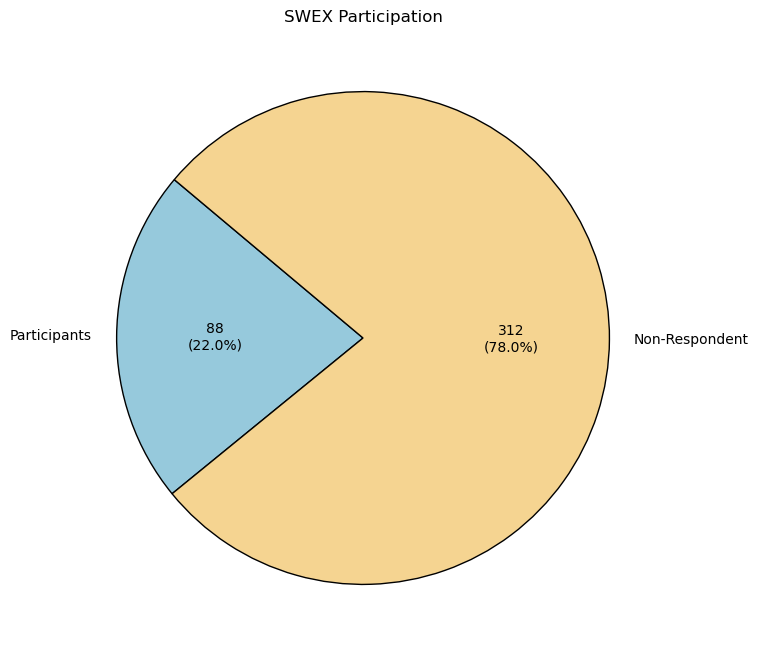

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Custom function to show both absolute value and percentage
def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f"{absolute}\n({pct:.1f}%)"

# Get the number of rows in the dataframe
num_rows_in_file = len(df)

# Set a fixed total of 400 rows
total_rows = 400

status_counts = {
    'Participants': num_rows_in_file,
    'Non-Respondent': total_rows - num_rows_in_file
}

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    status_counts.values(), 
    labels=status_counts.keys(), 
    autopct=lambda pct: func(pct, status_counts.values()), 
    startangle=140, 
    colors=['#96C9DC', '#F5D491'], 
    wedgeprops={'edgecolor': 'black'})

plt.title('SWEX Participation')
plt.show()

## Vote Distribution for Topic

Index(['index', 'Novice', 'Advanced Beginner', 'Competent', 'Proficient',
       'Expert', 'Remove', 'Unclear', 'Max Level', 'Is Unclear', 'Is Remove',
       'Is Agreement', 'Agreement'],
      dtype='object')


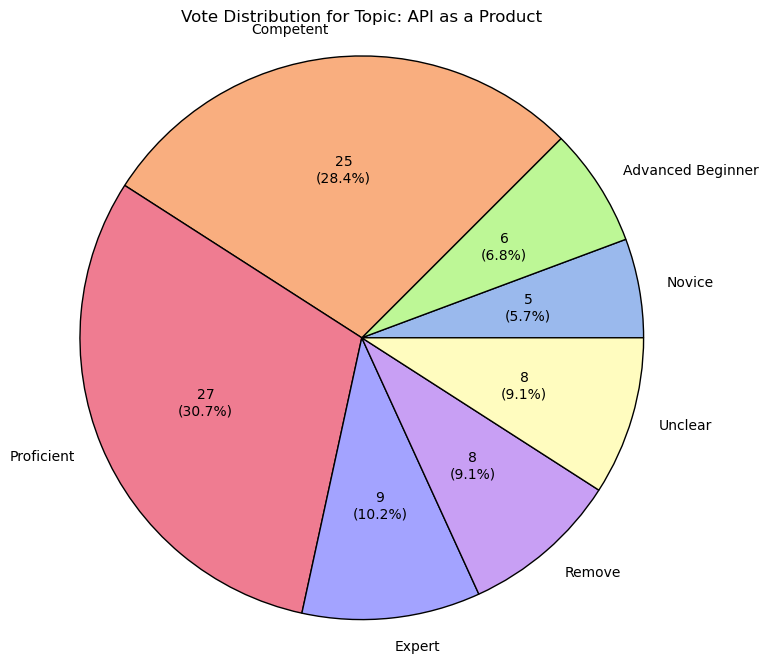

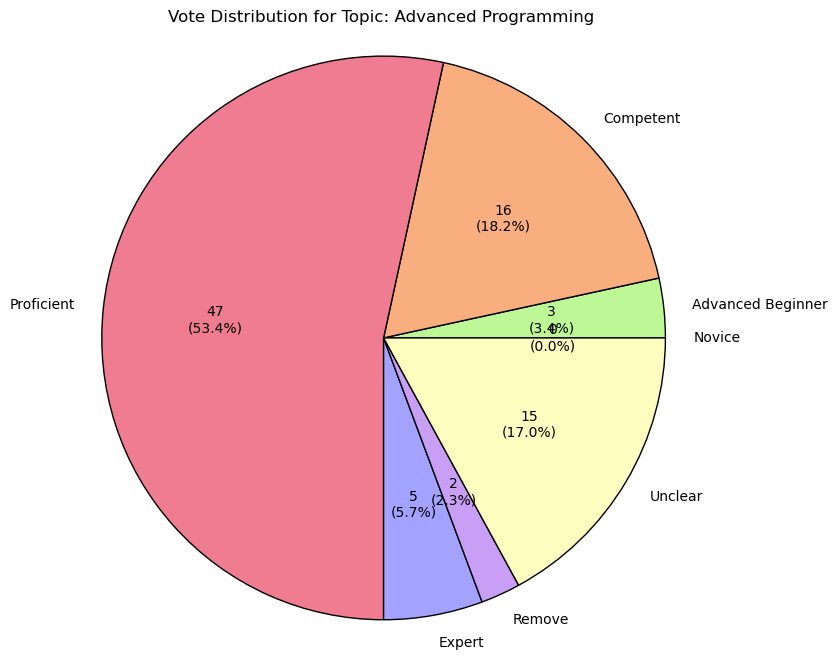

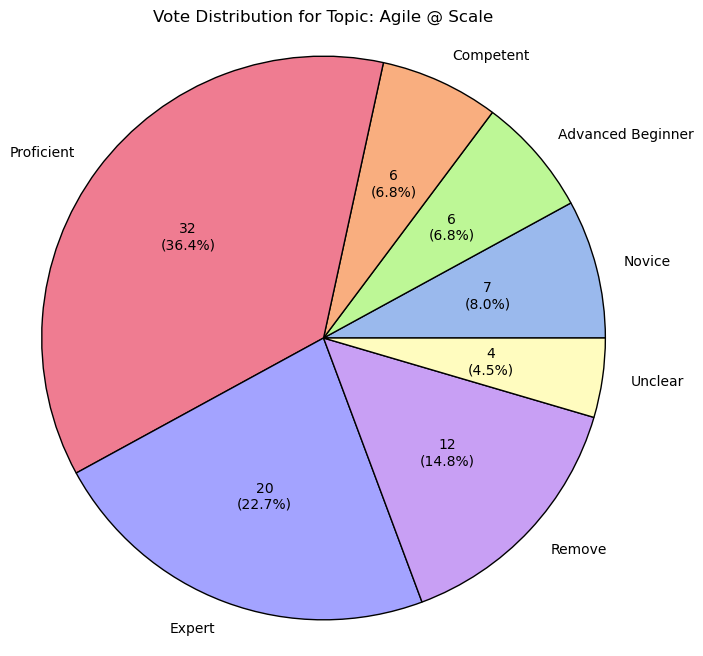

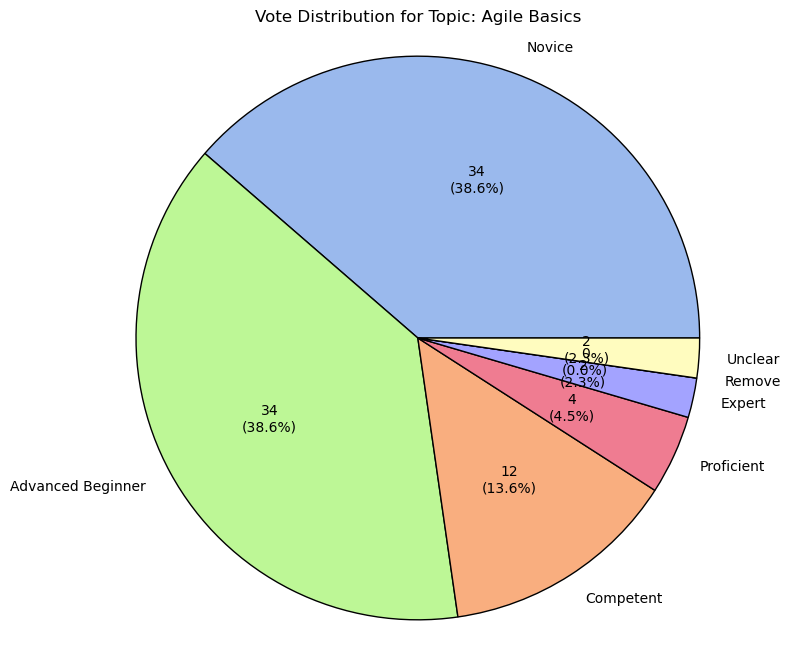

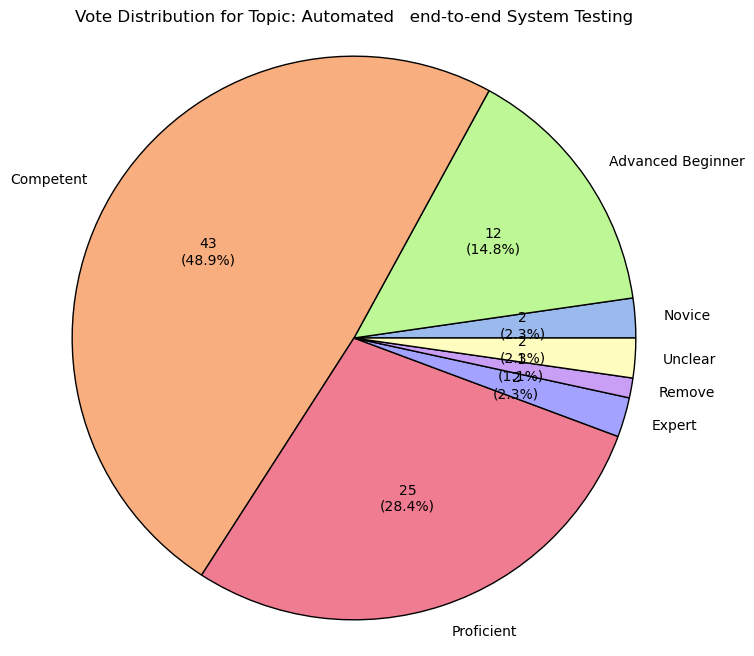

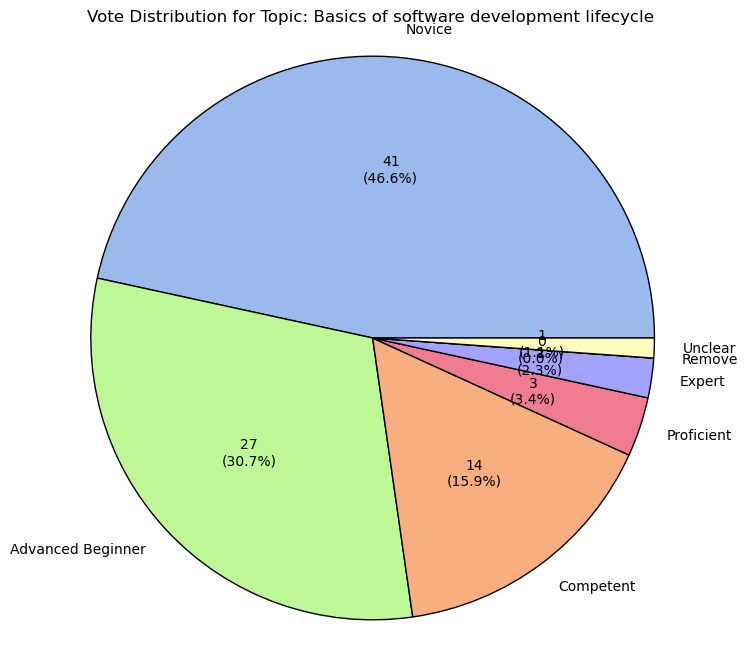

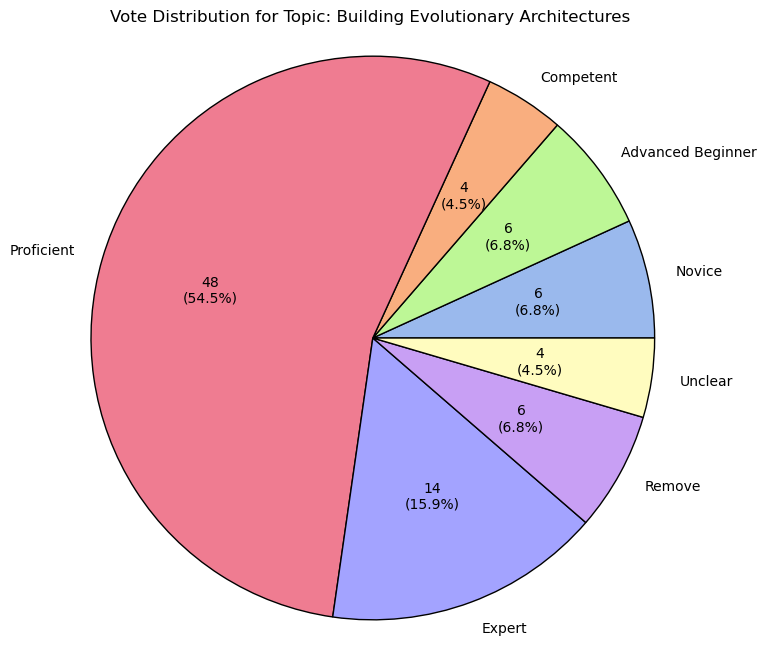

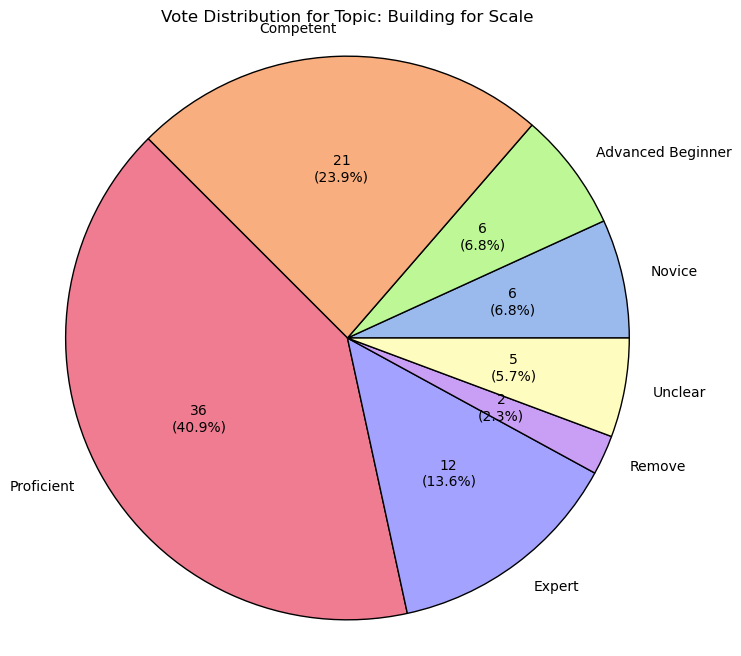

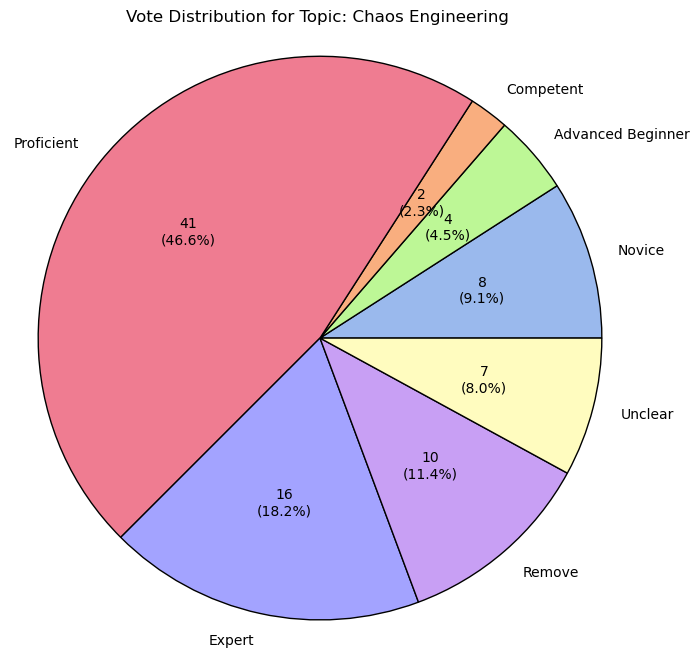

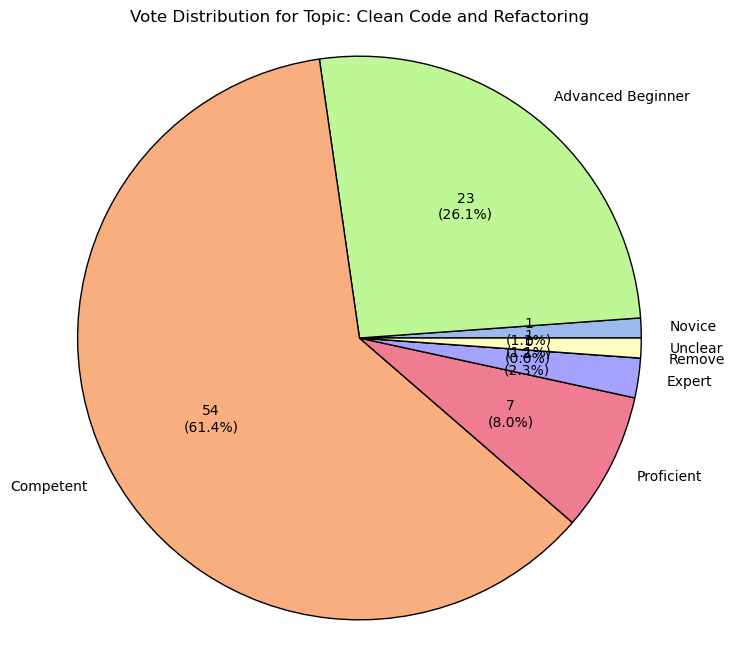

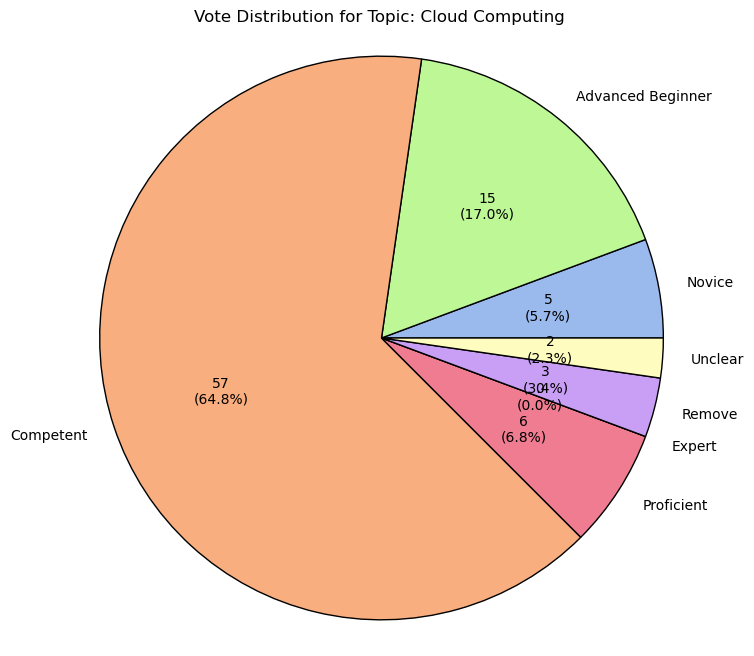

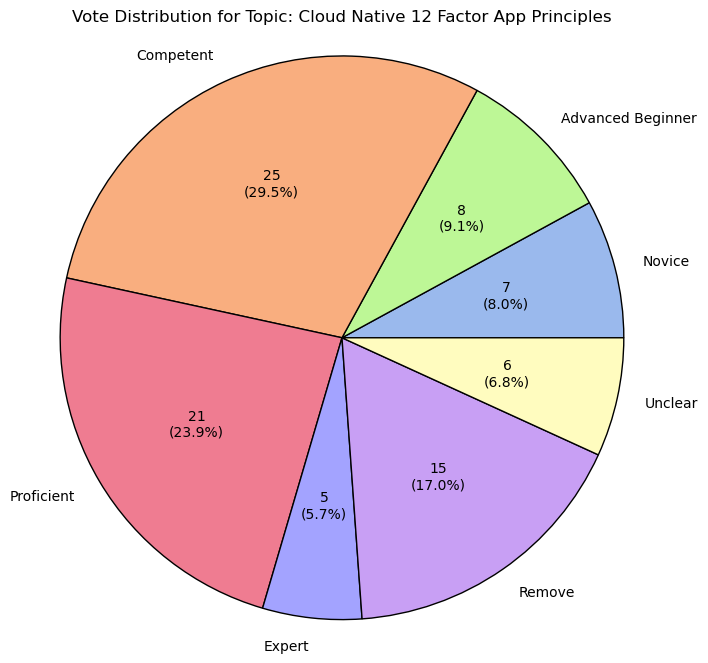

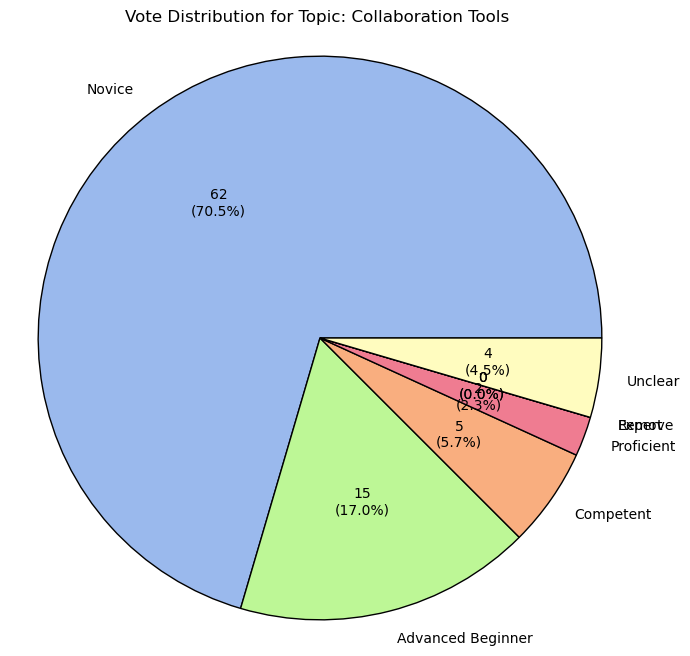

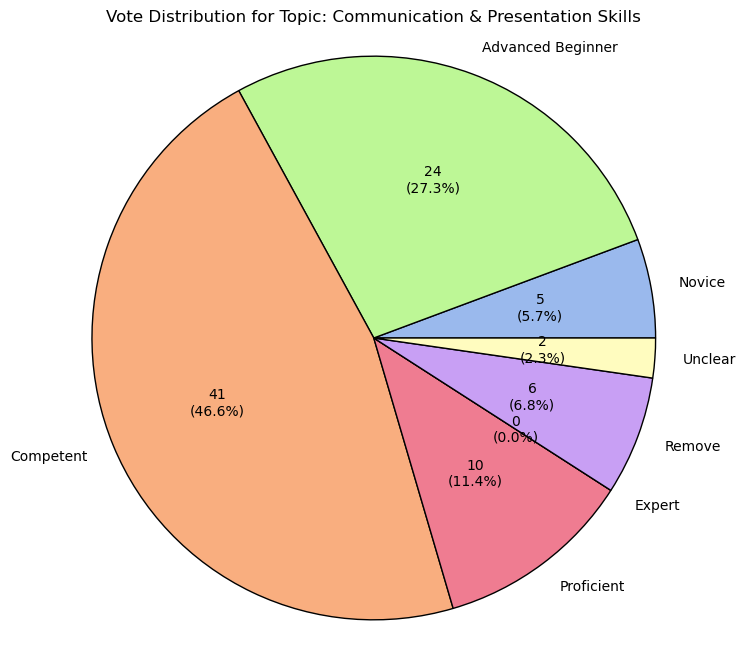

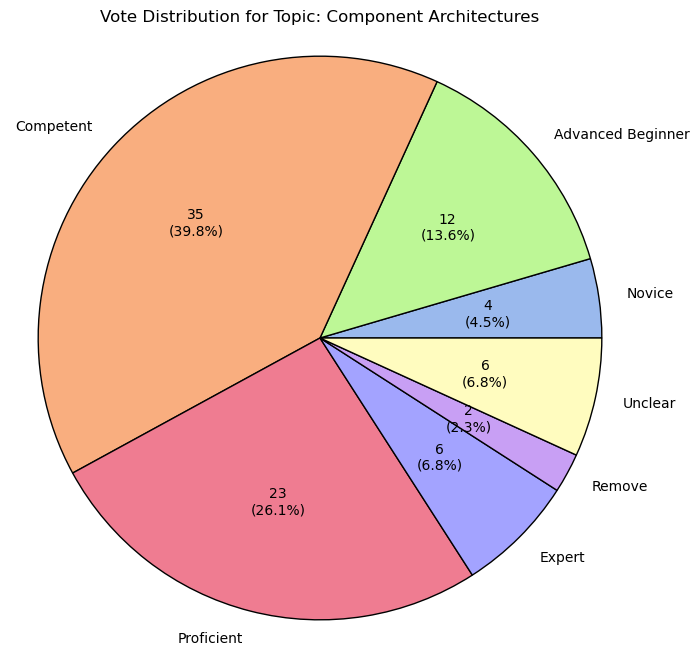

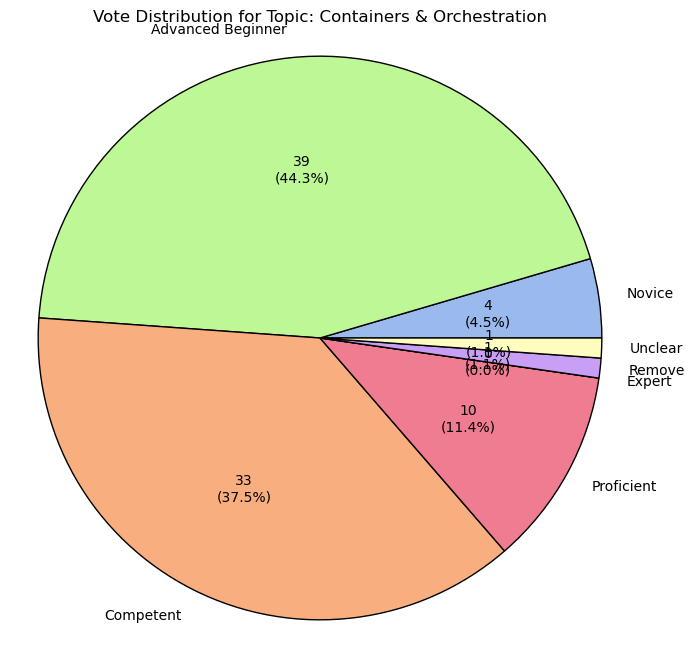

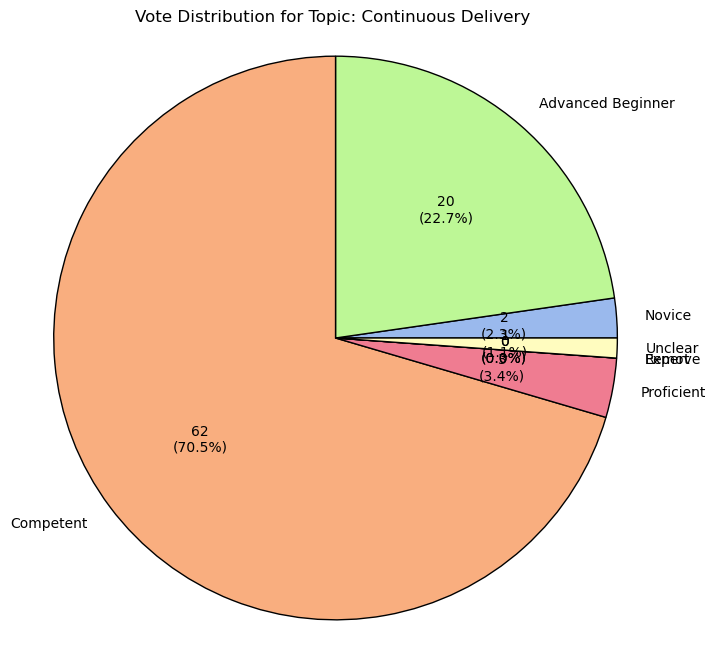

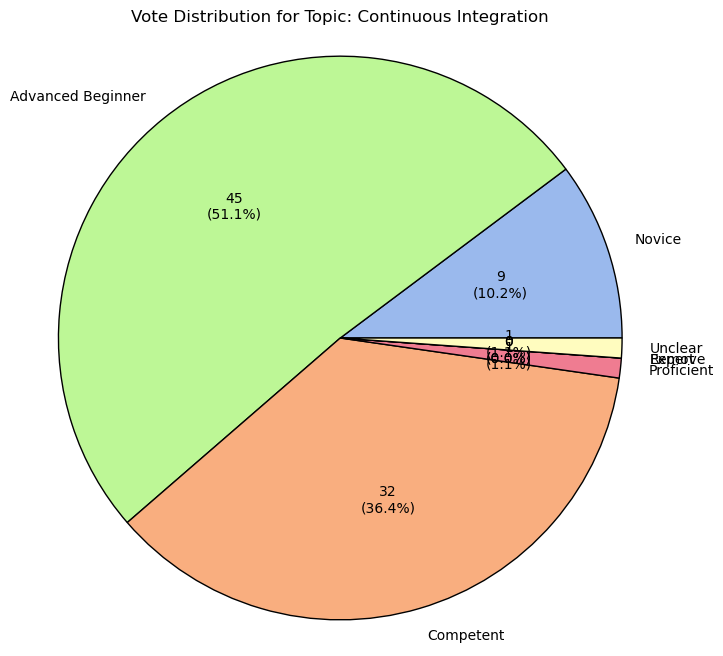

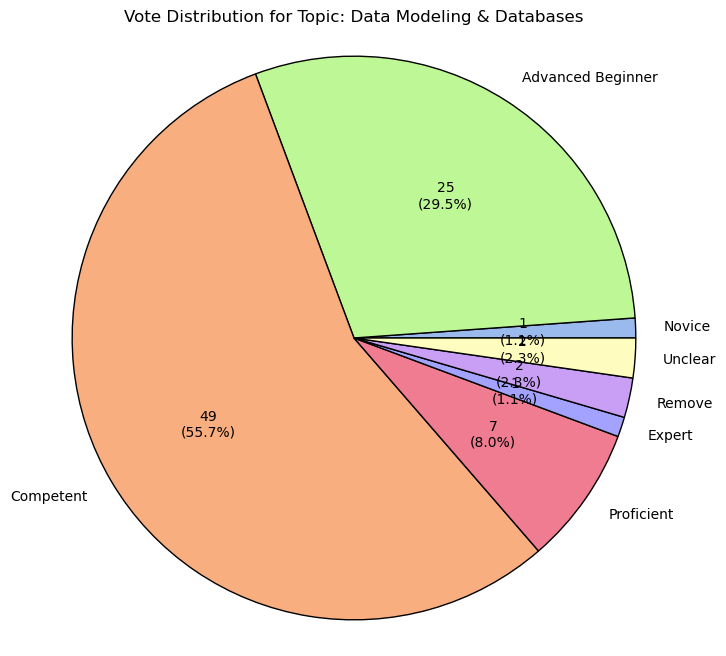

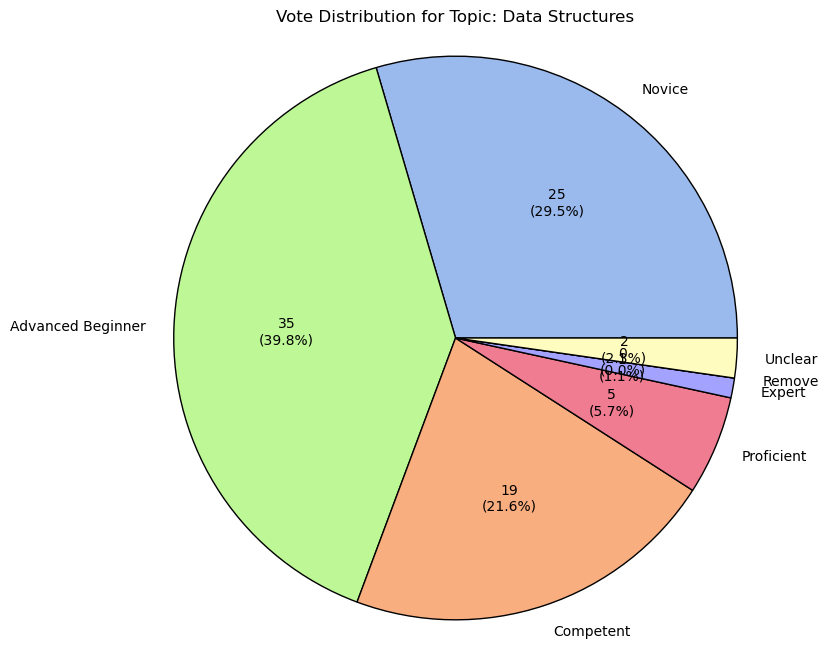

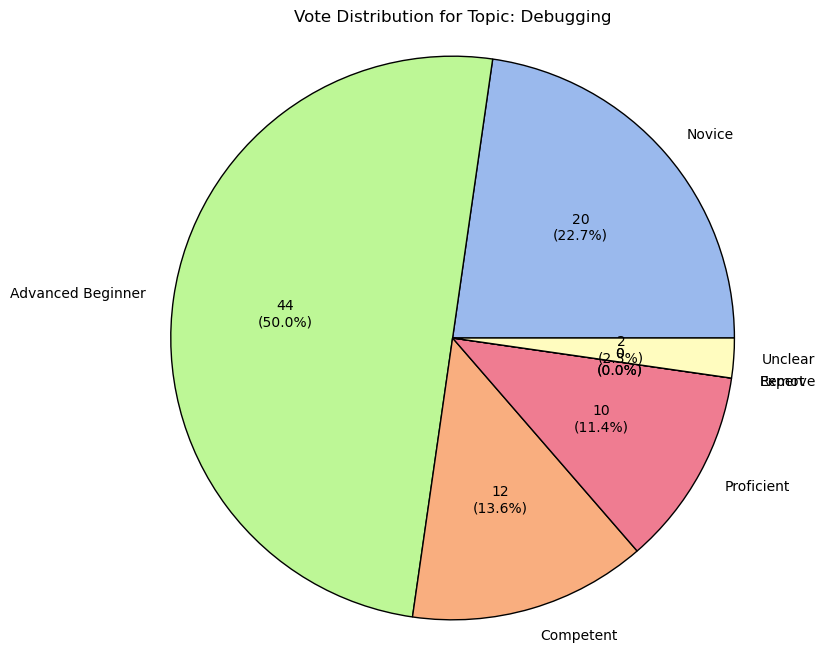

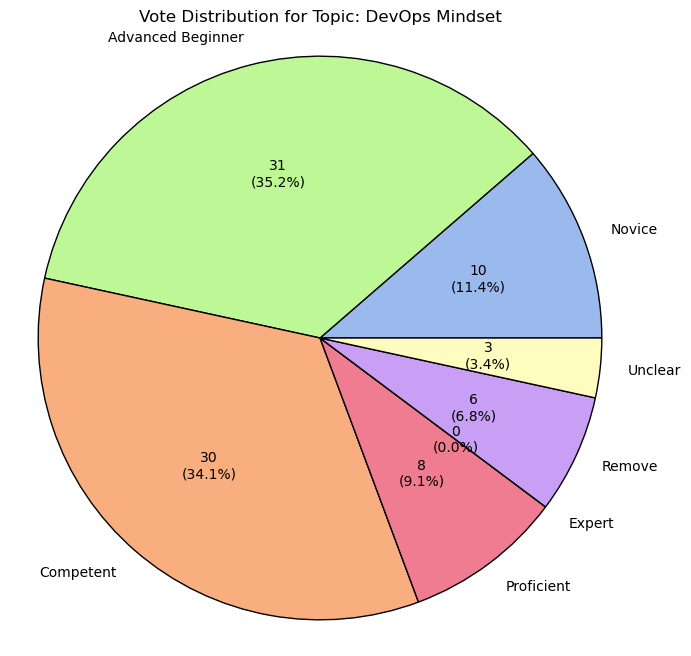

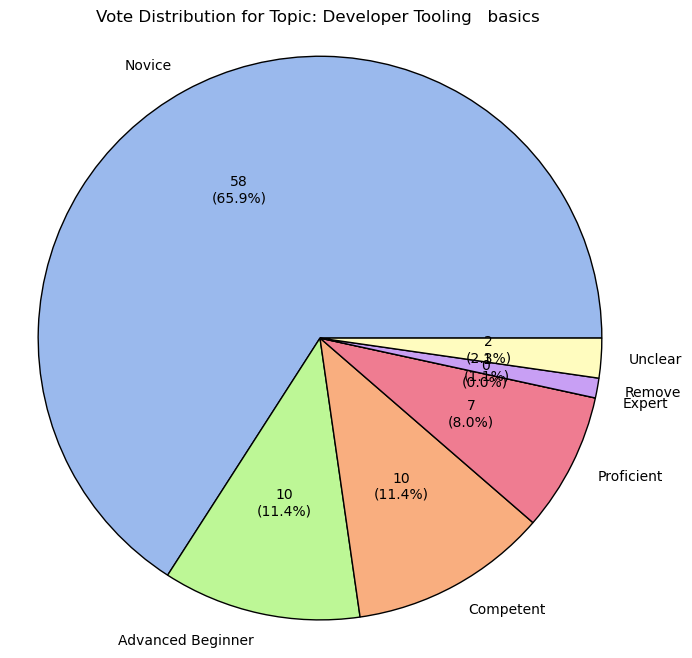

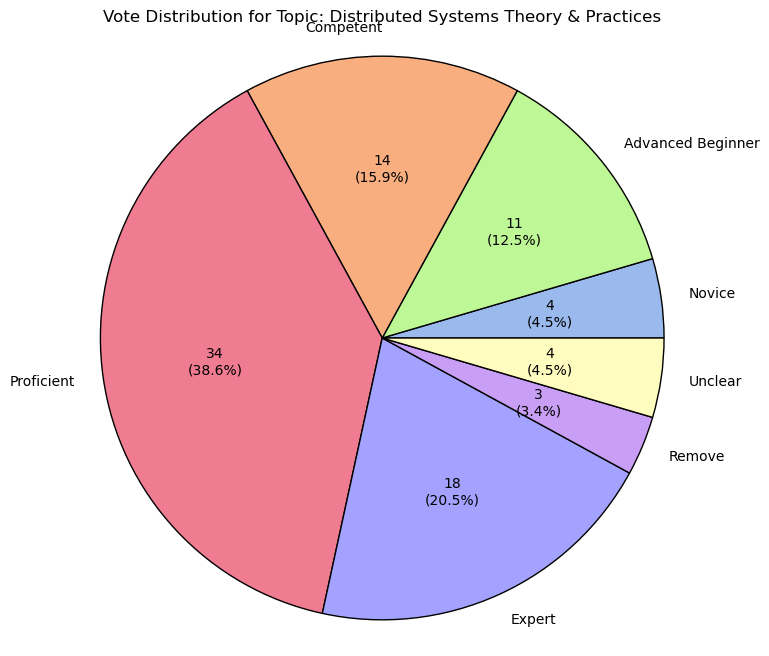

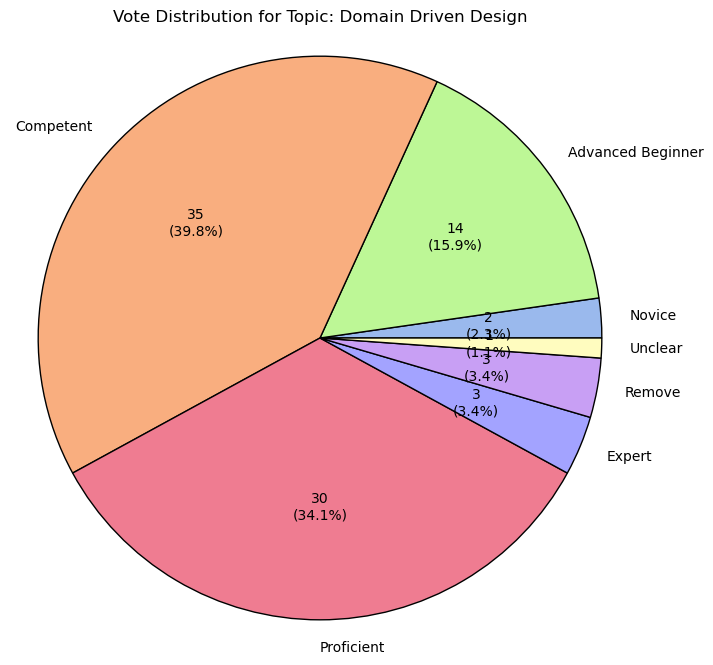

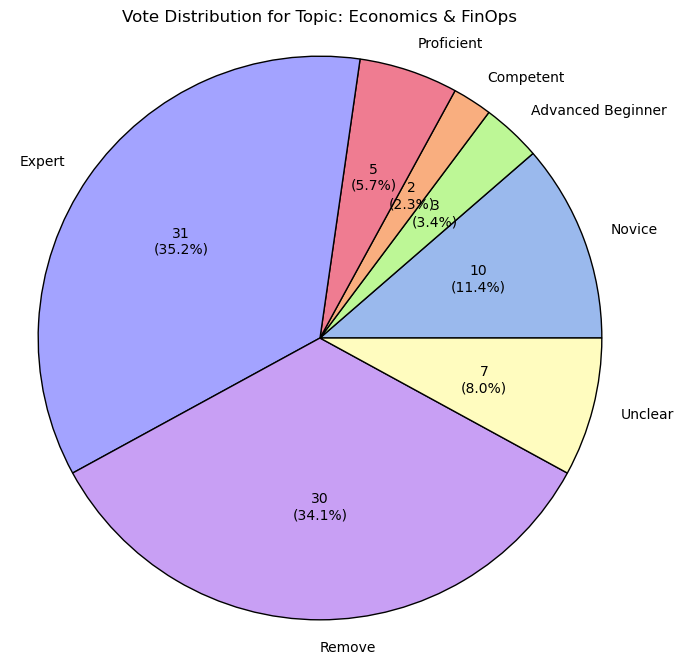

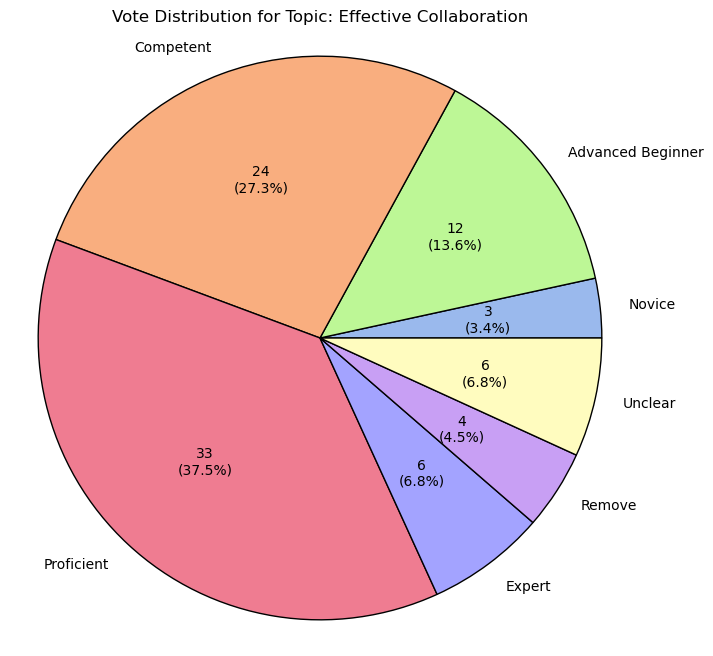

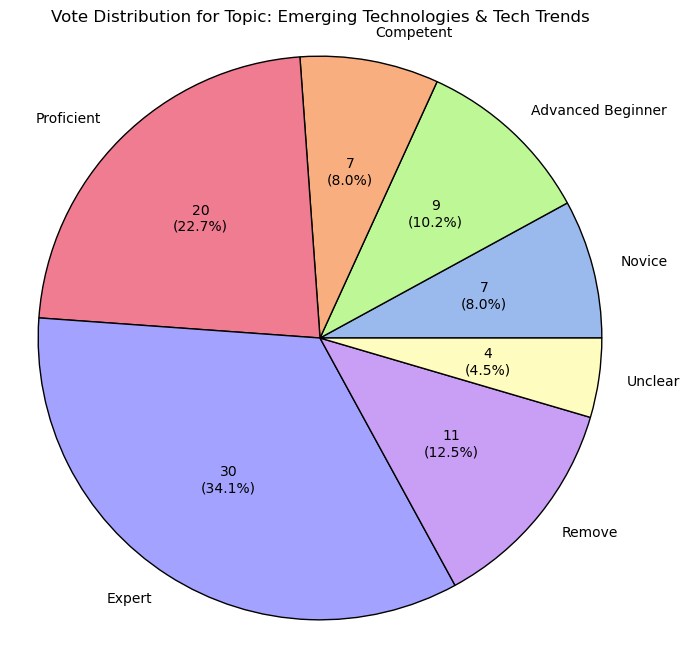

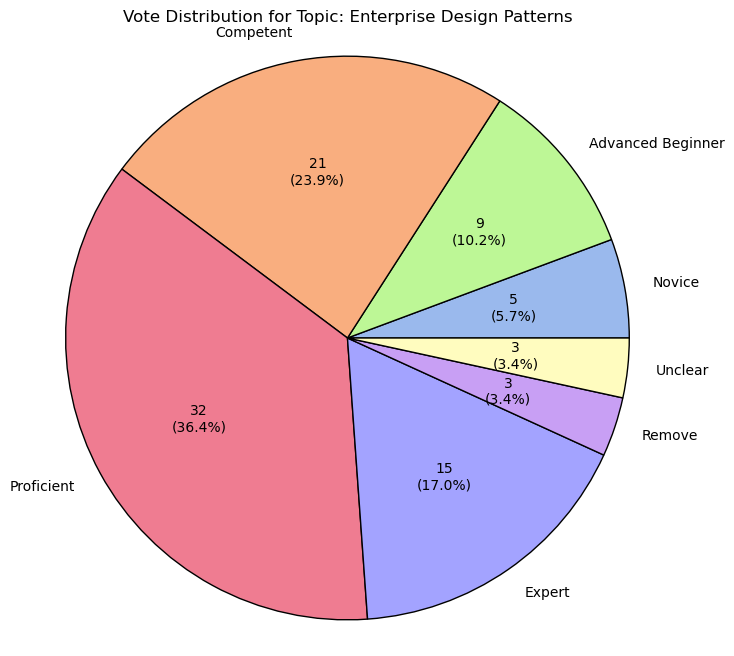

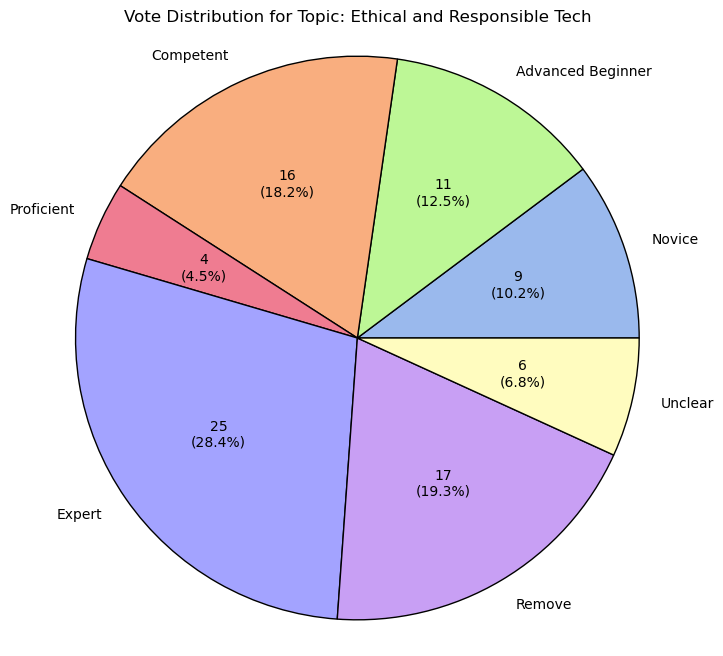

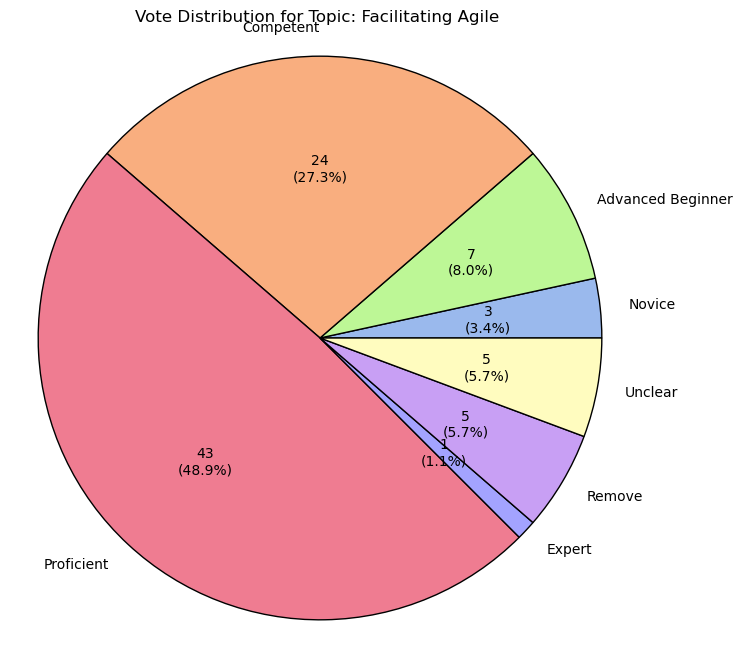

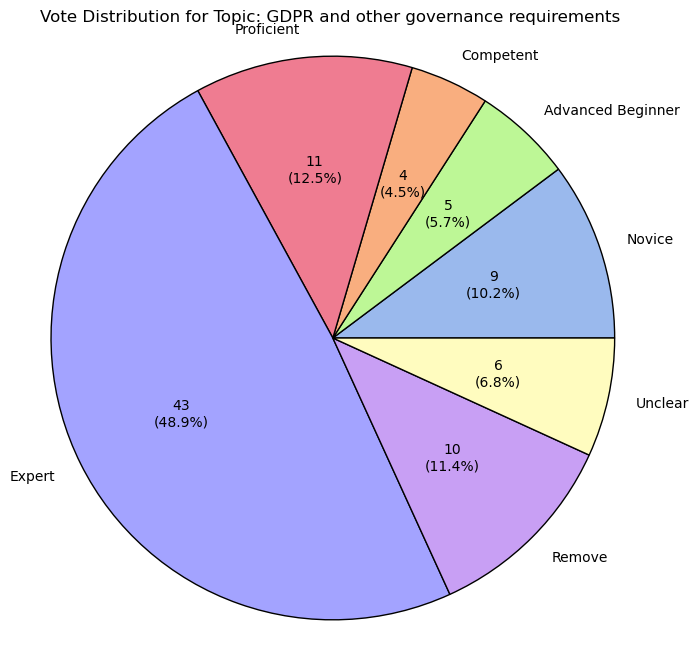

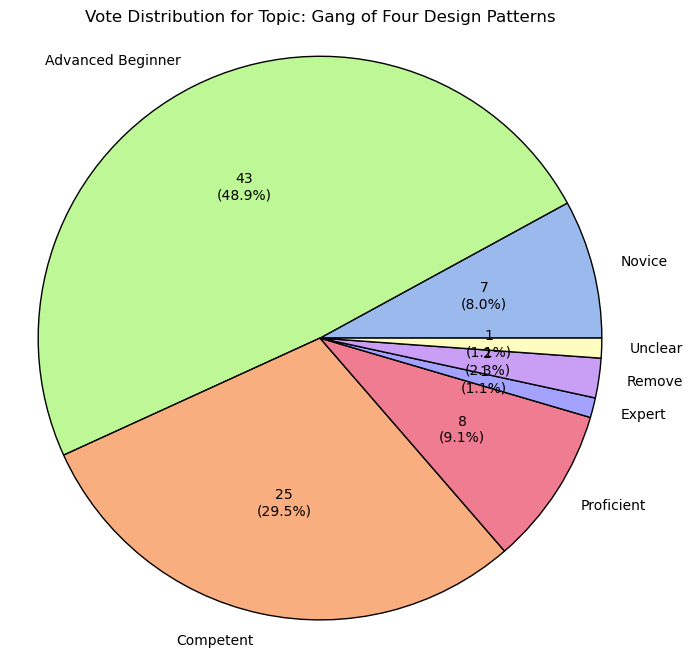

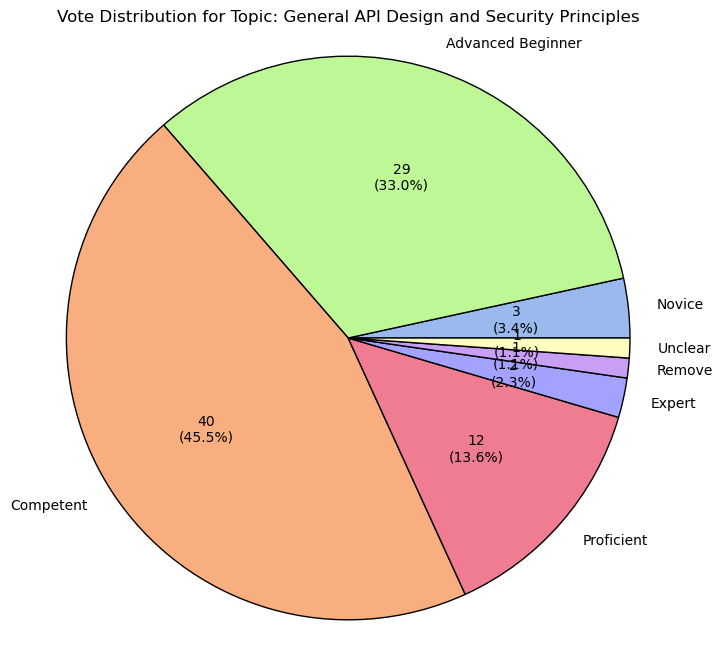

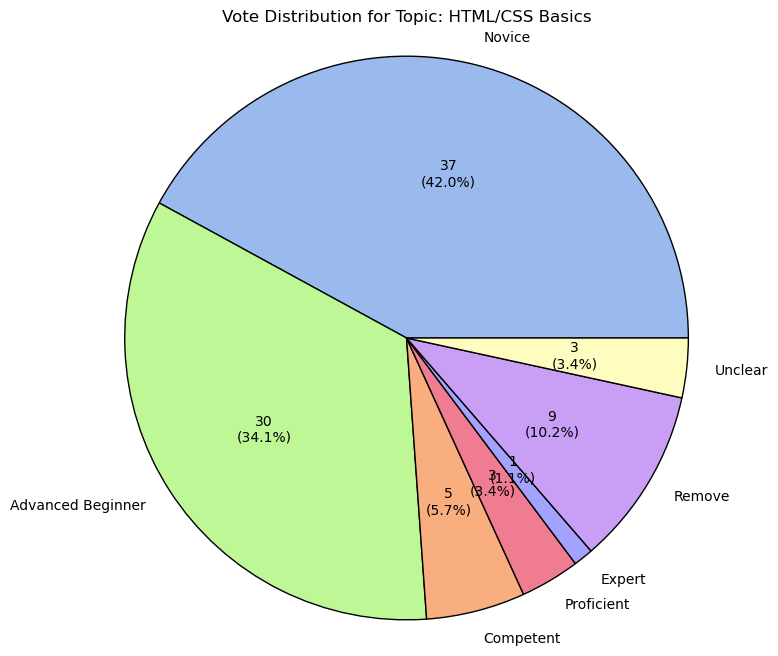

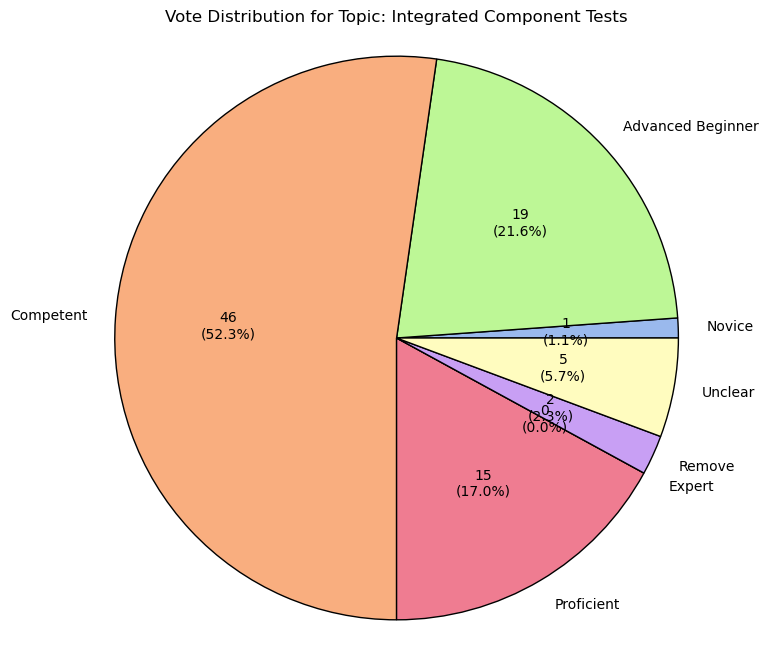

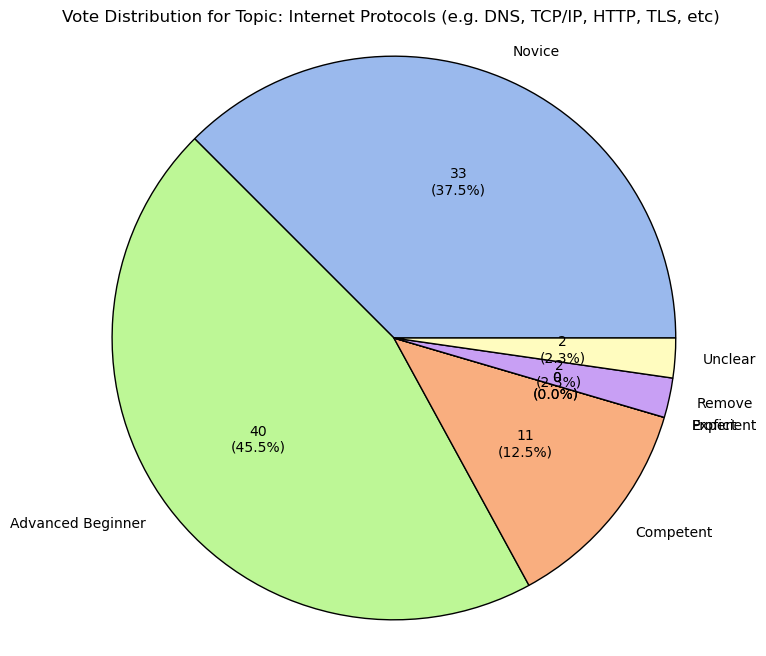

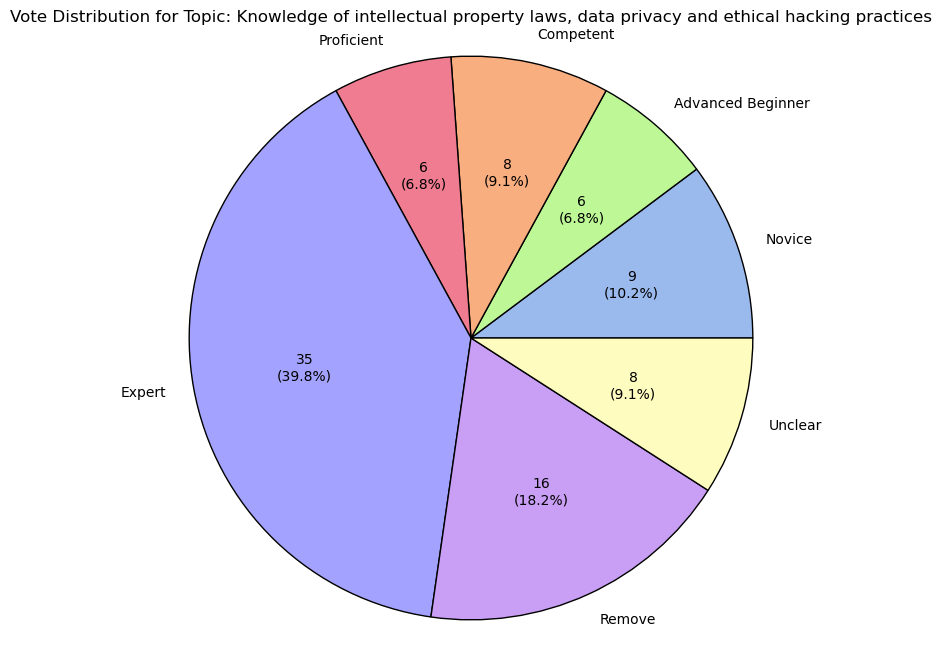

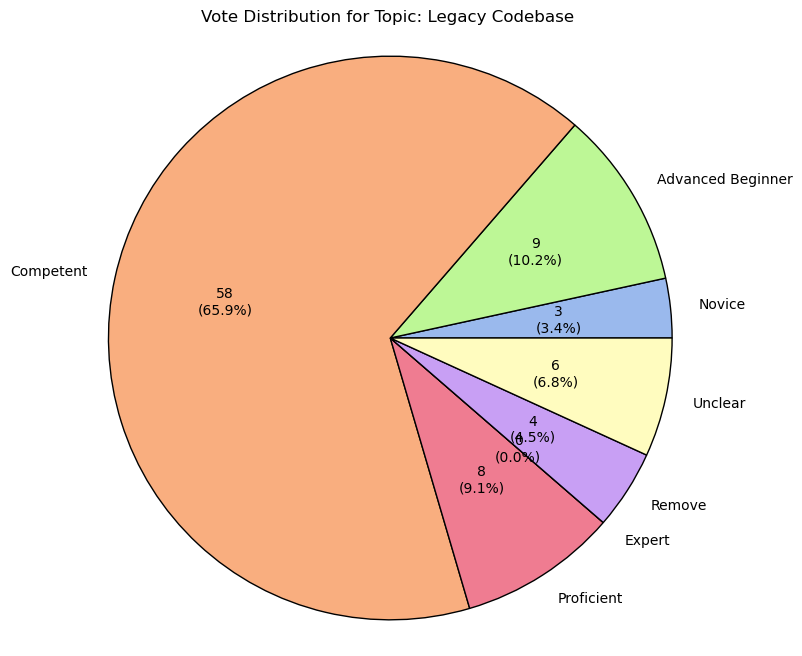

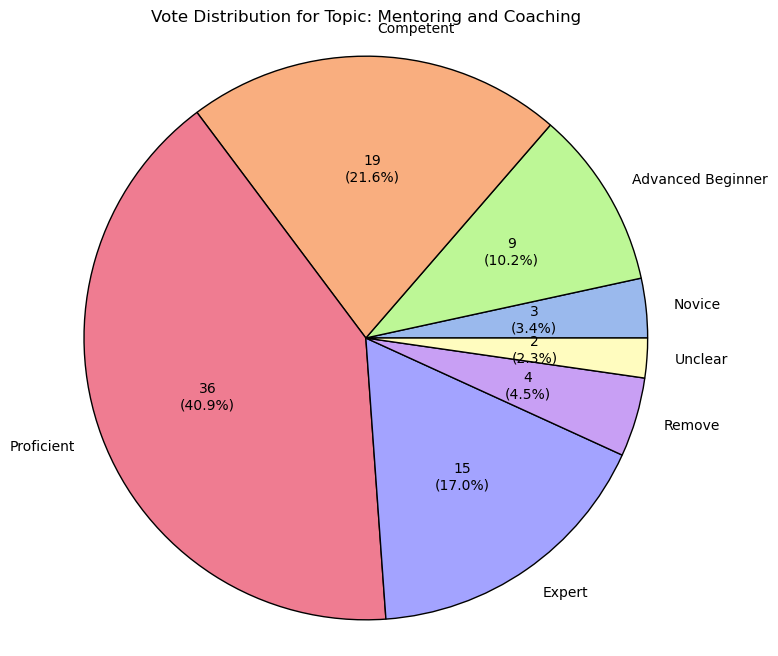

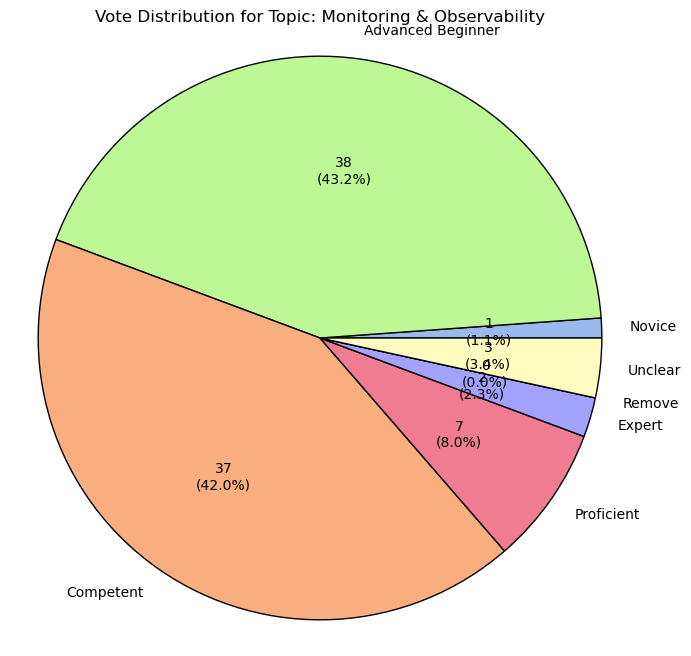

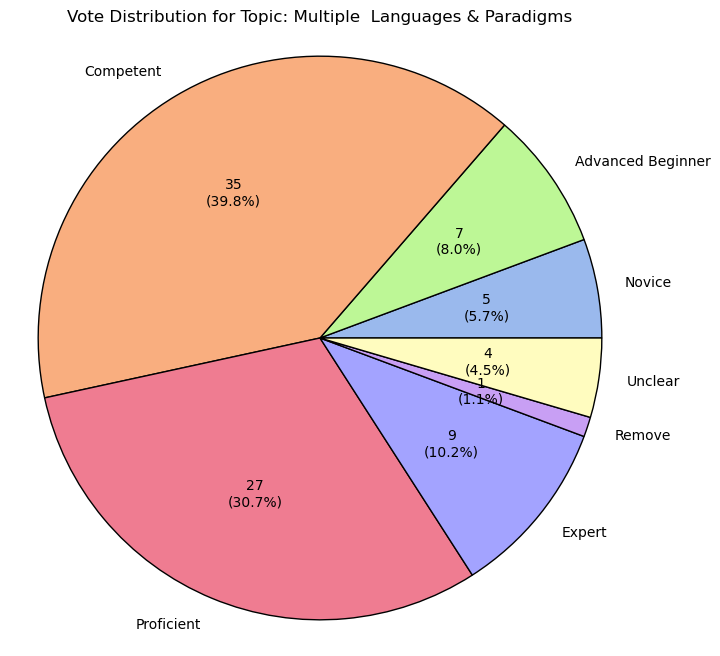

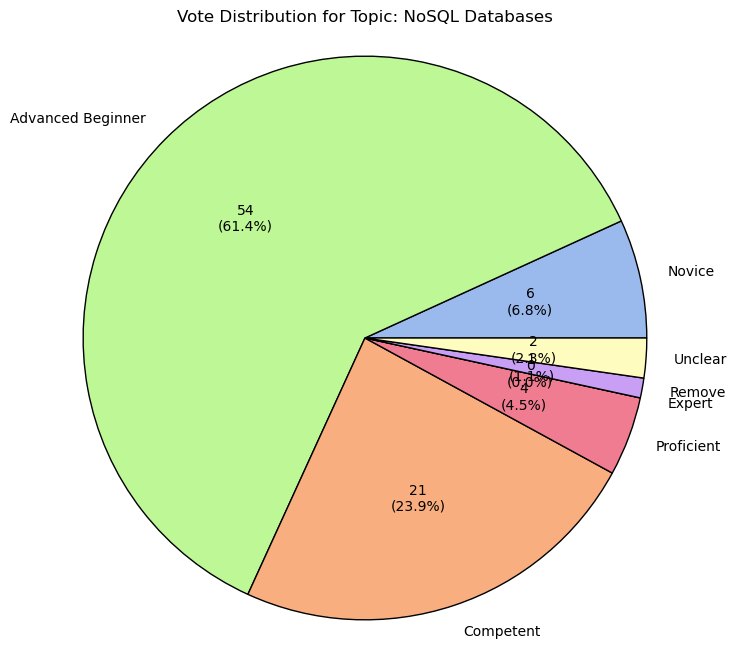

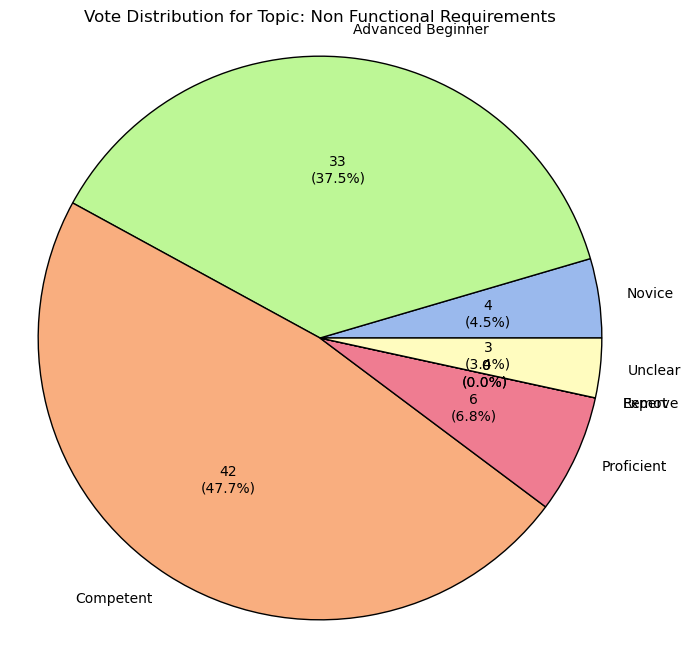

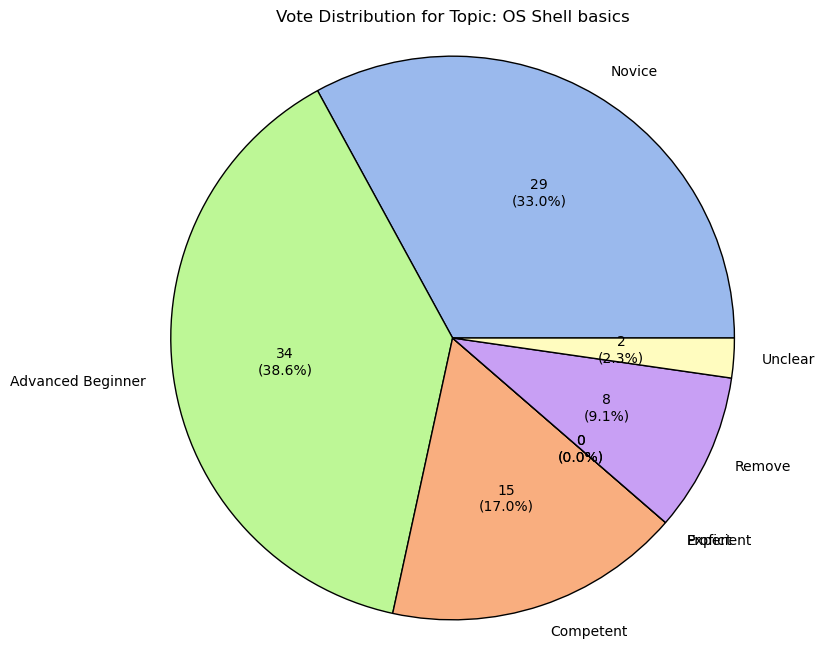

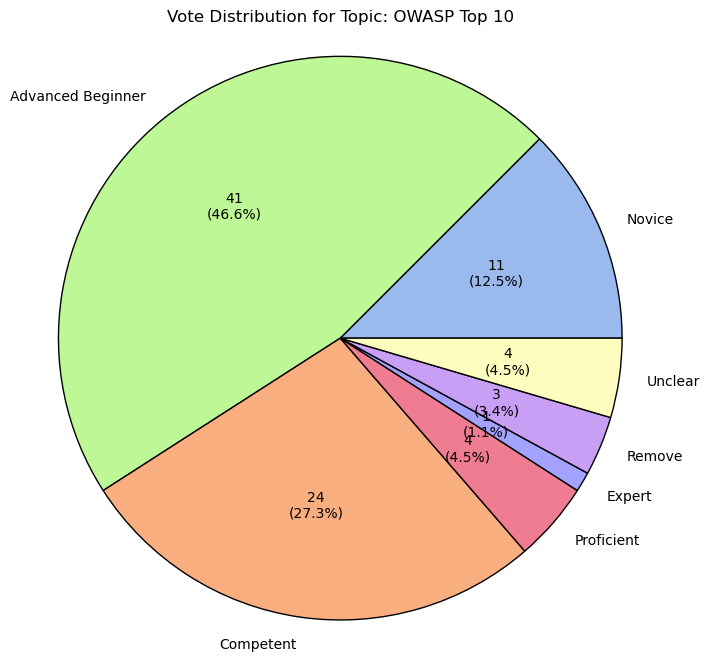

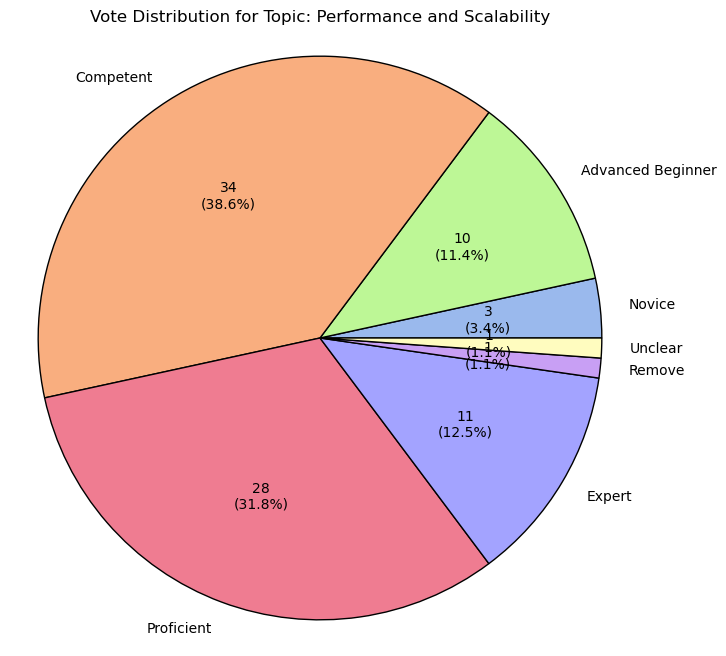

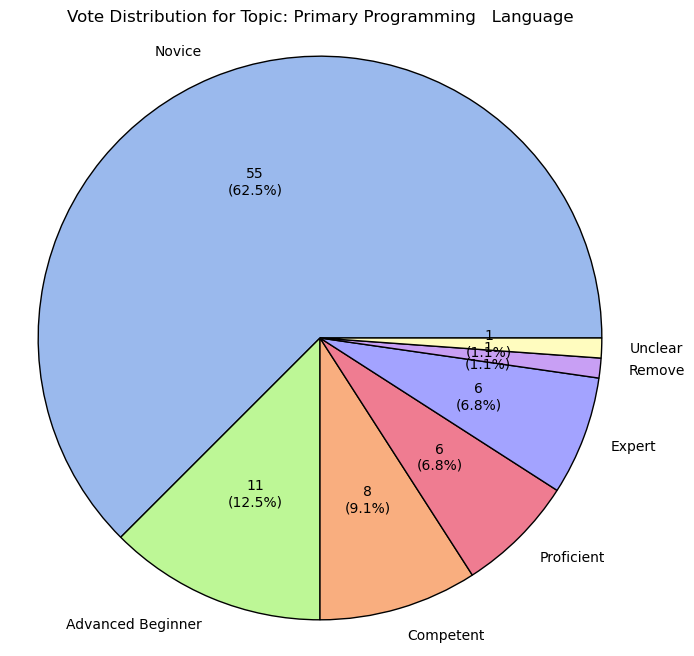

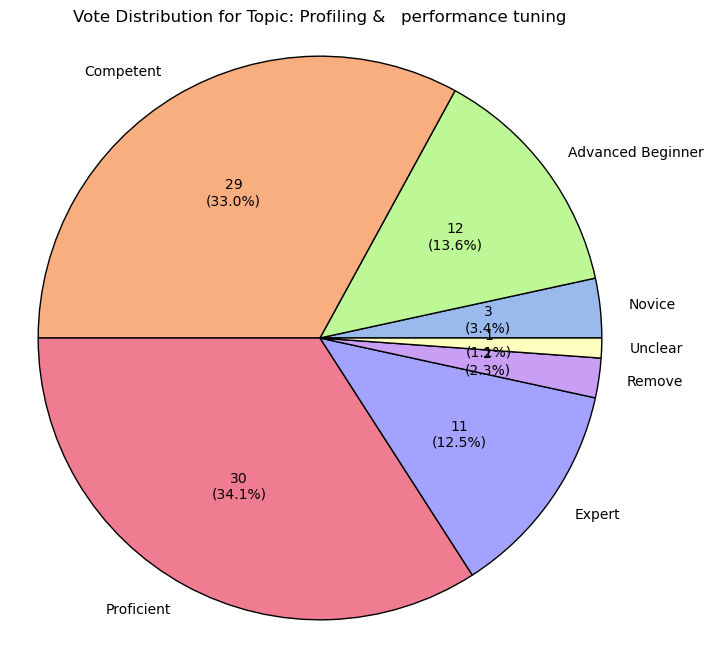

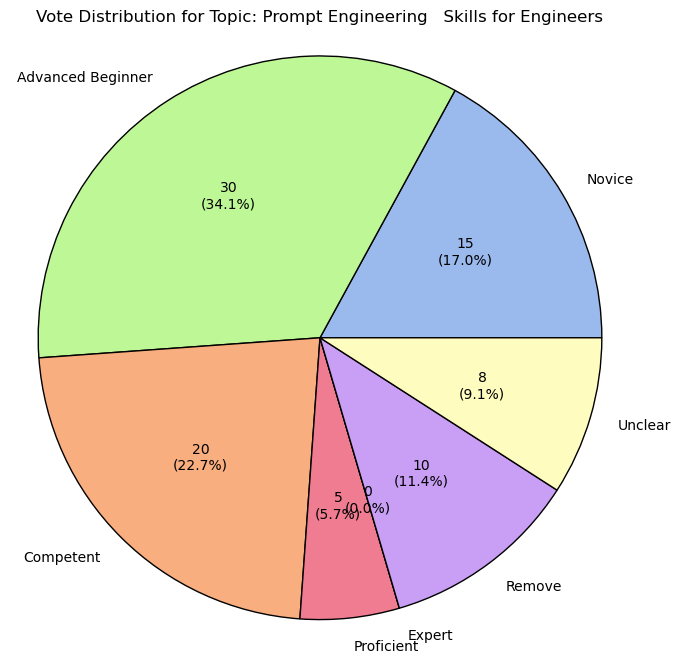

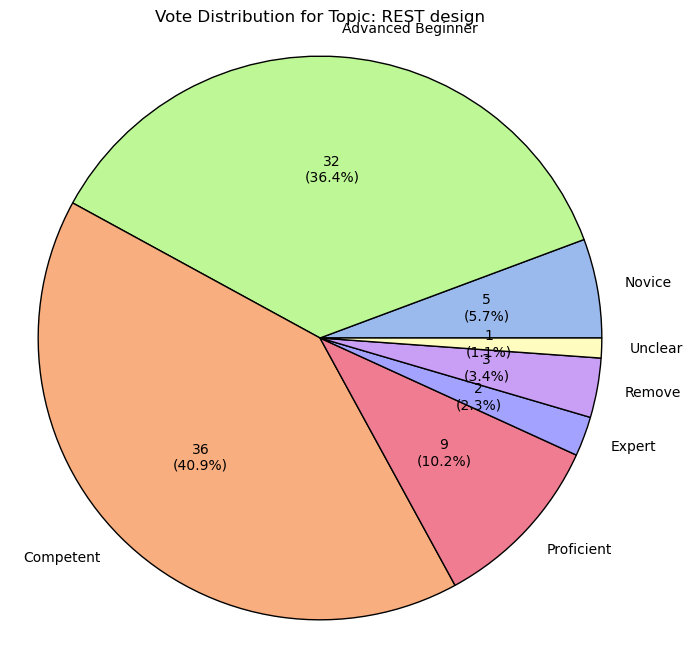

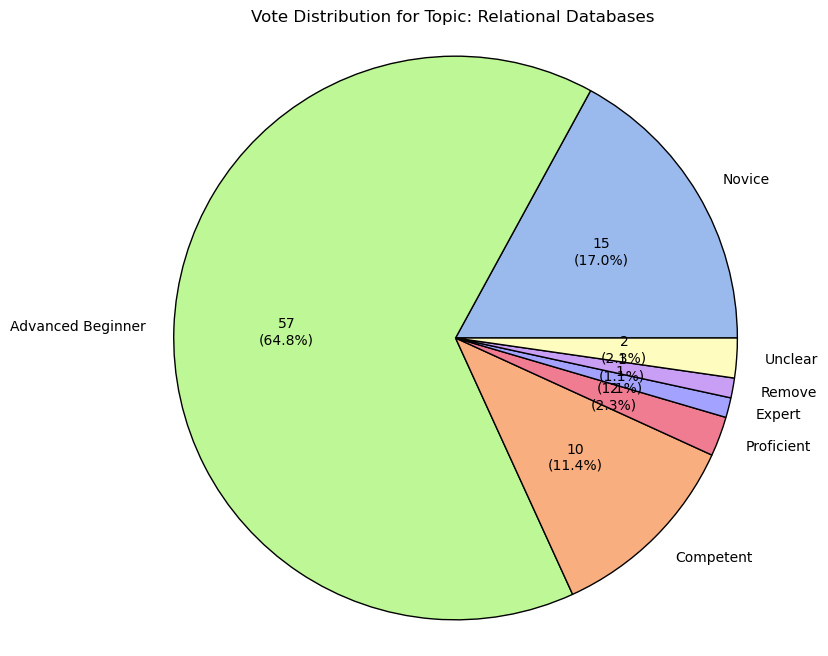

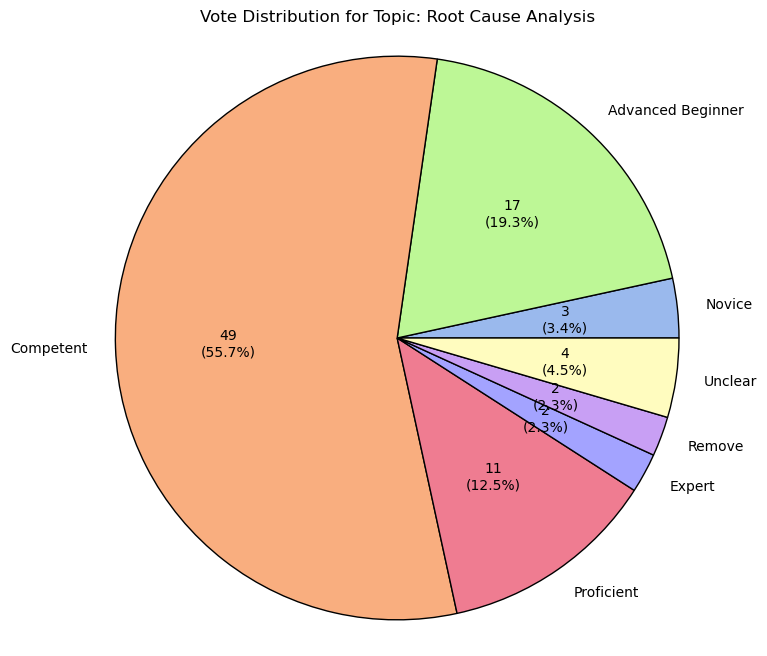

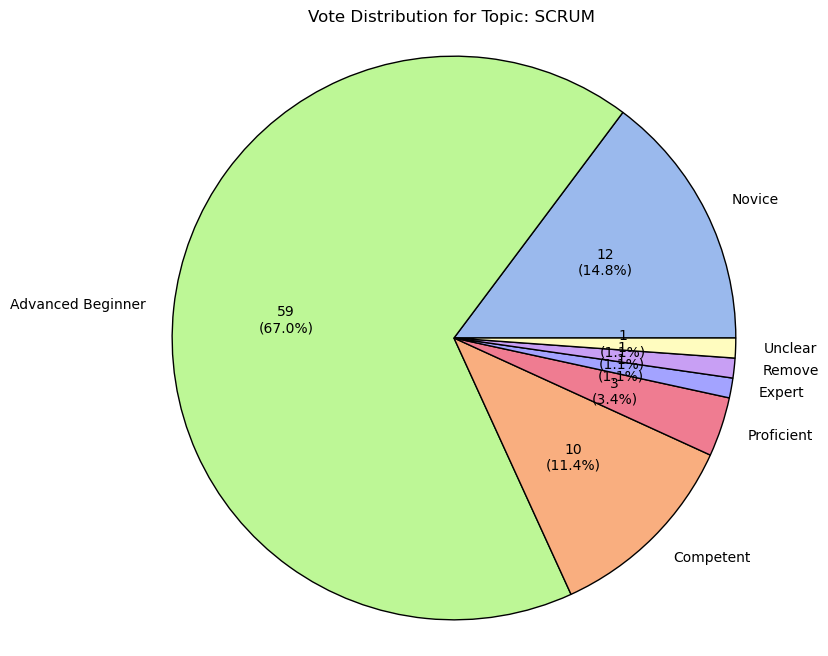

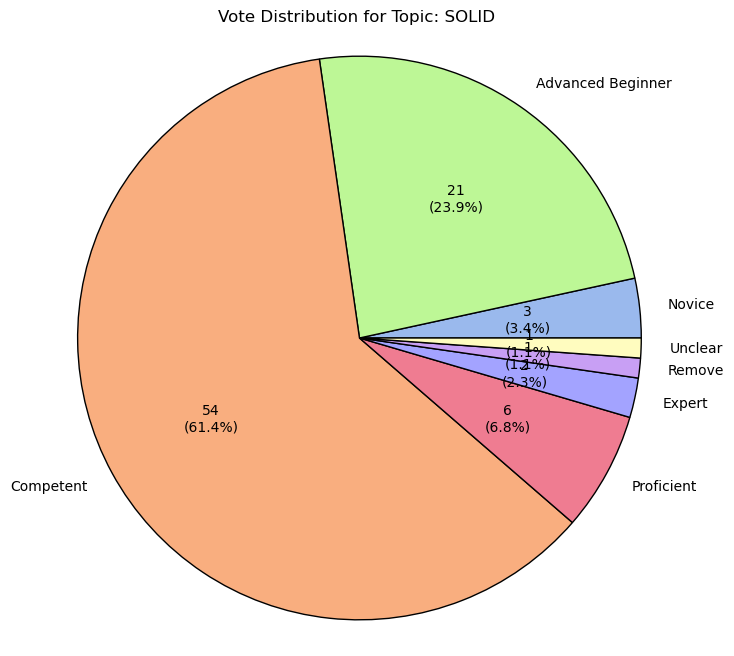

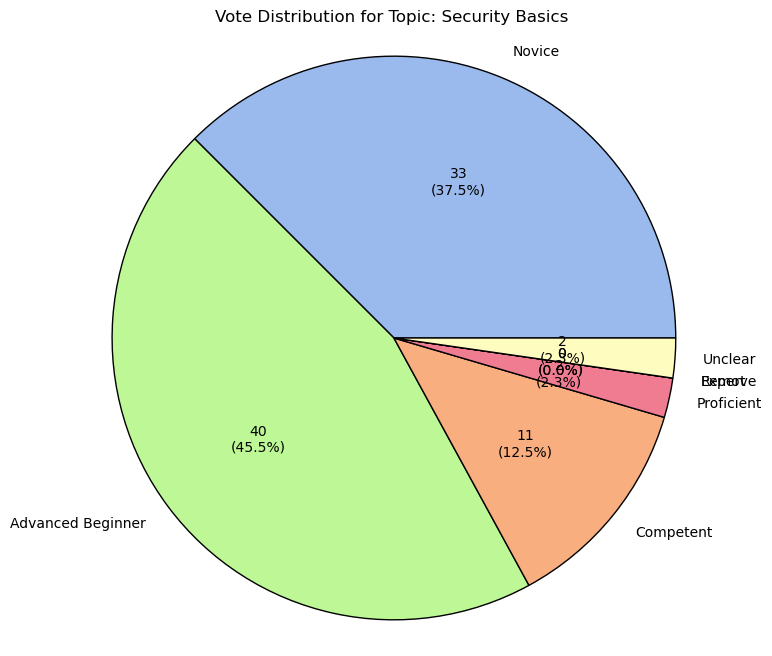

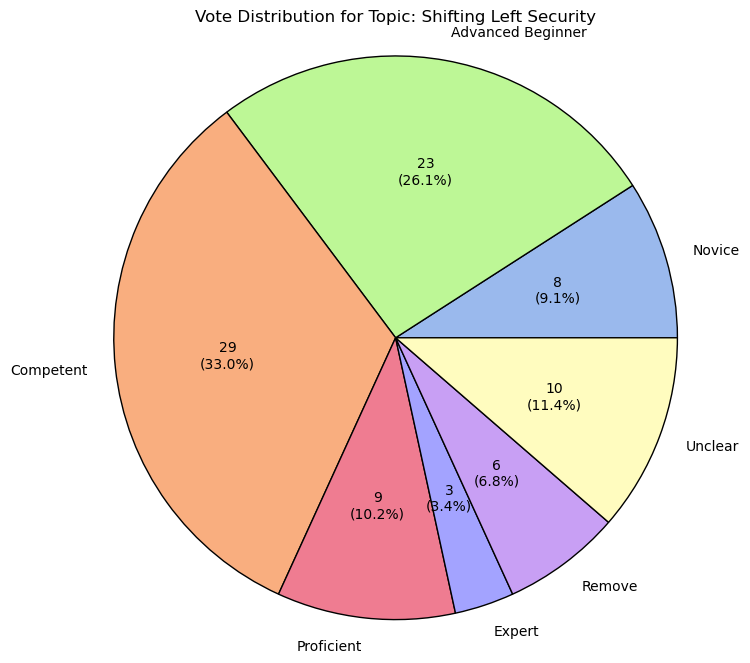

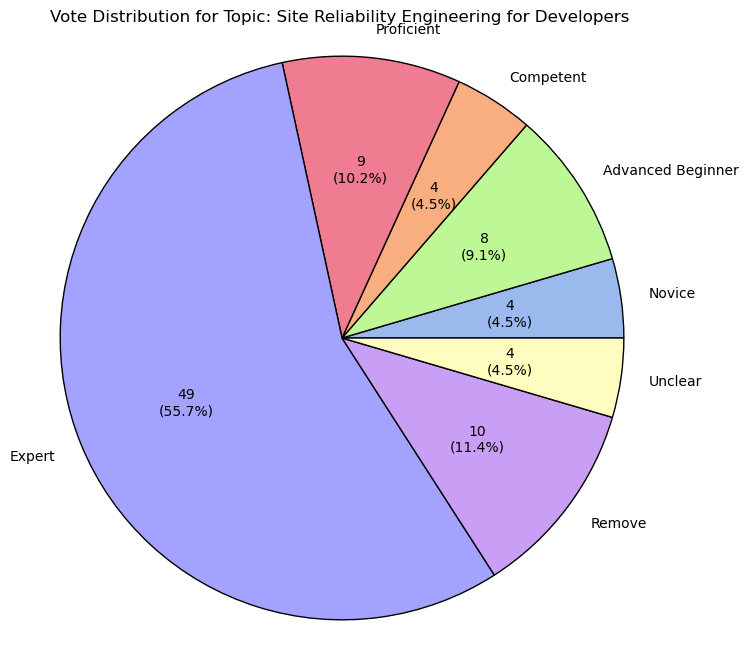

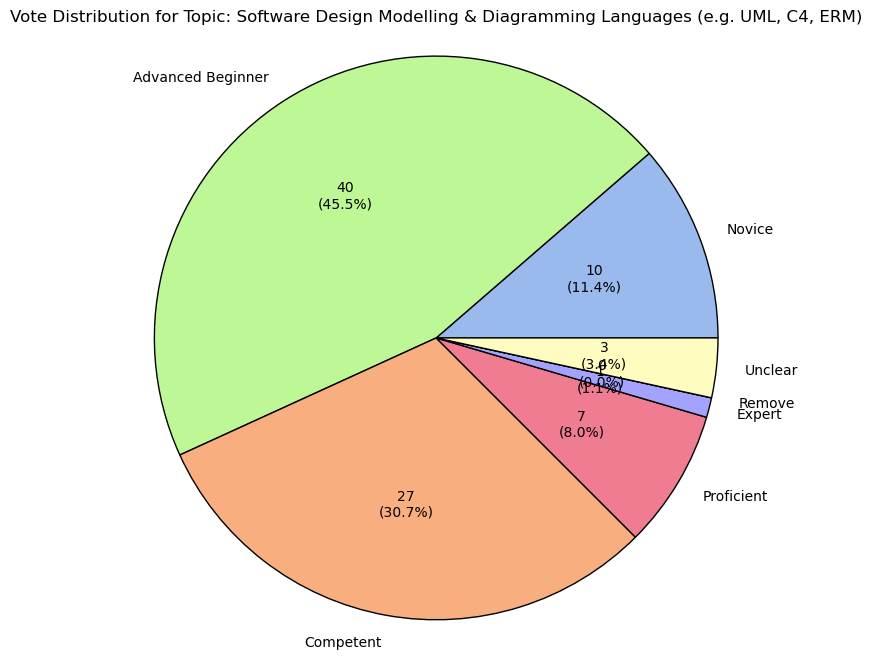

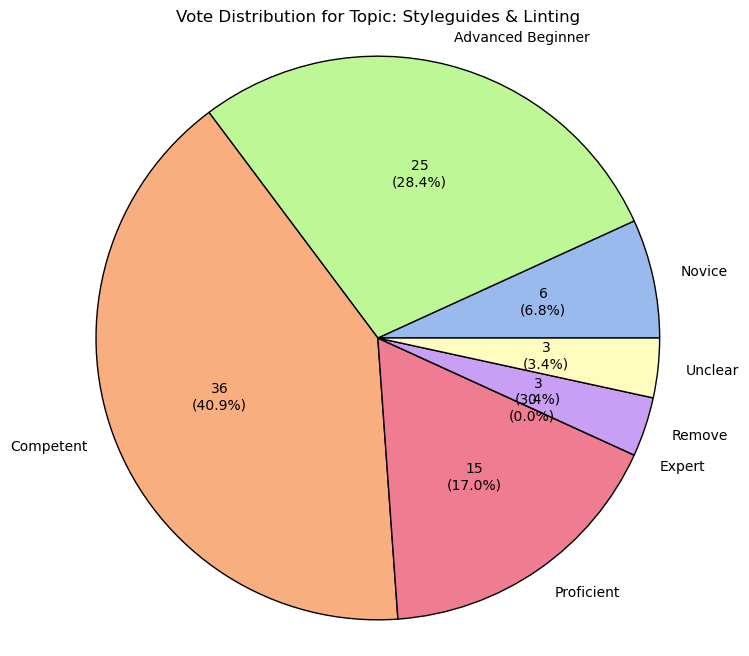

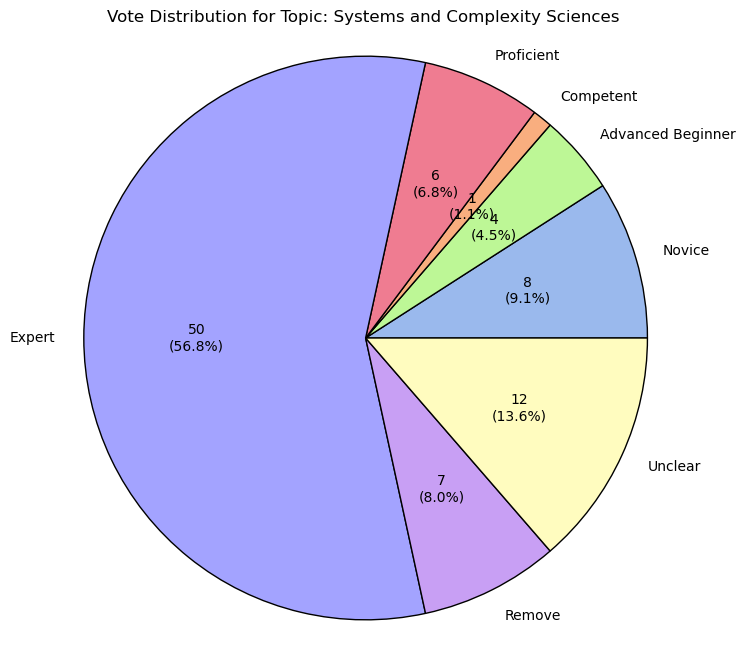

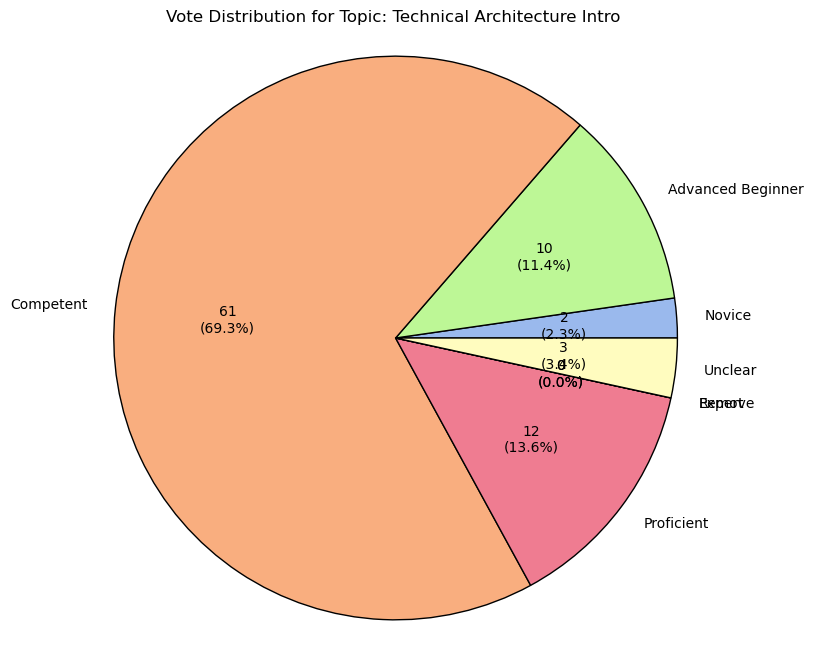

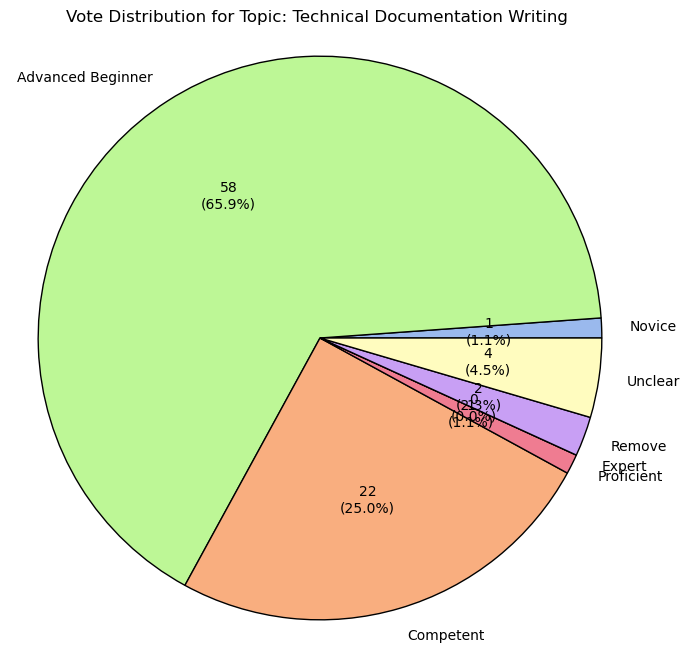

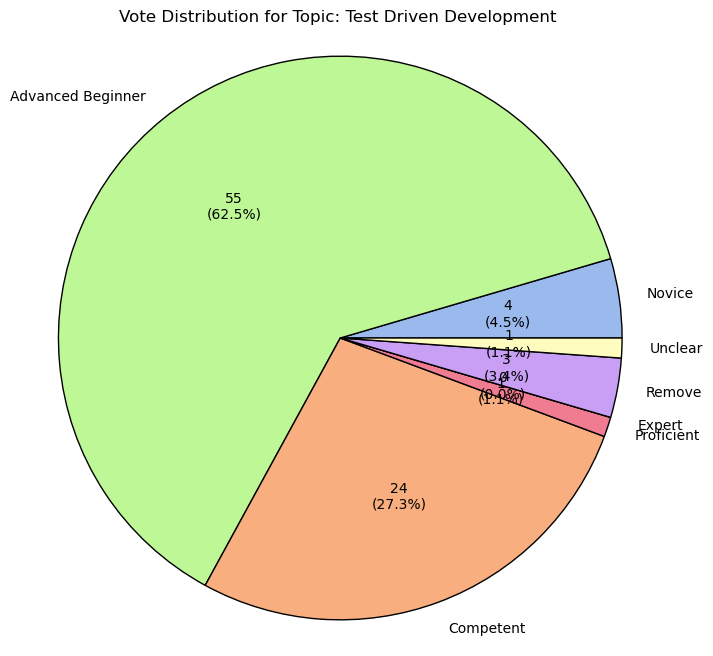

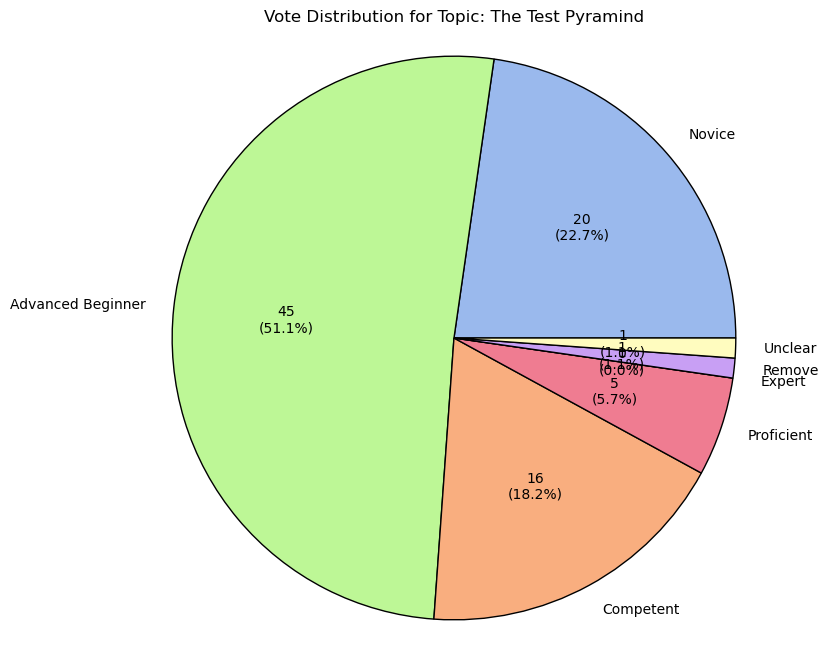

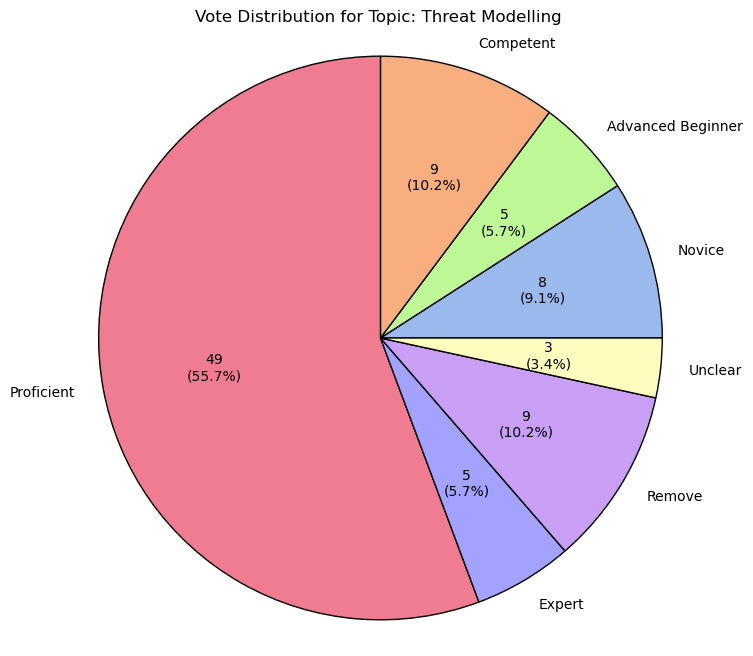

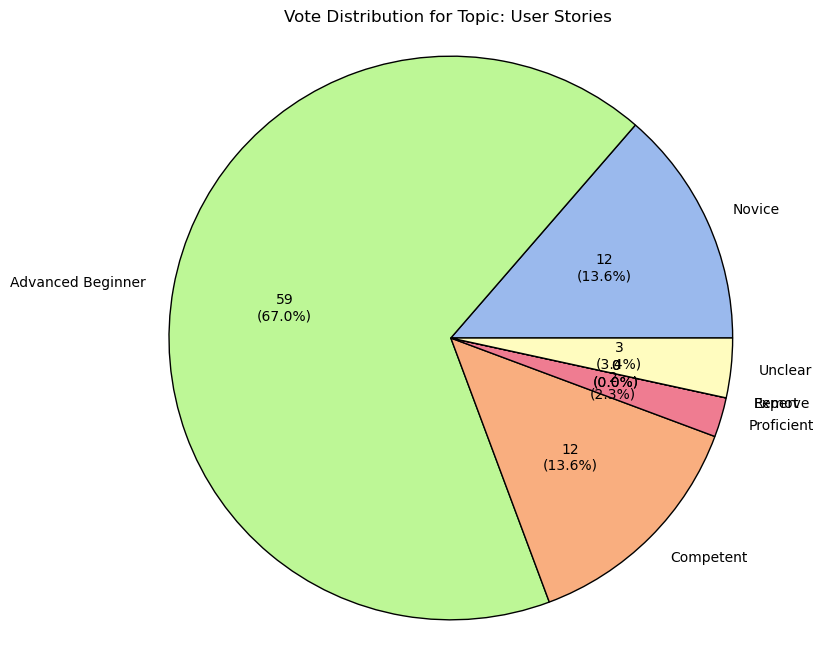

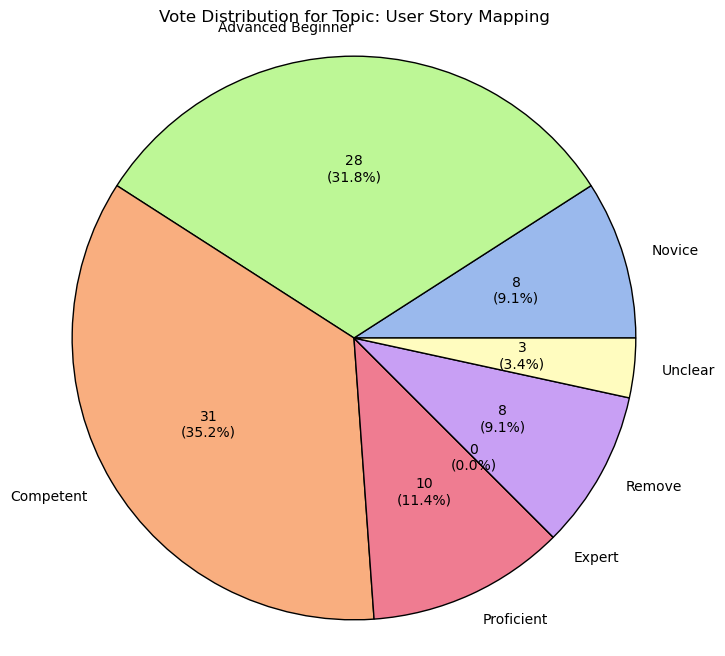

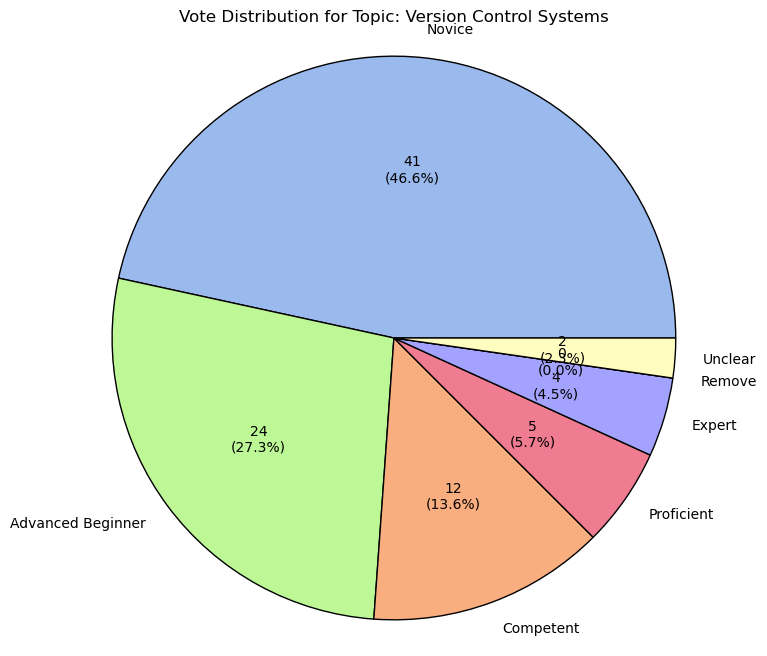

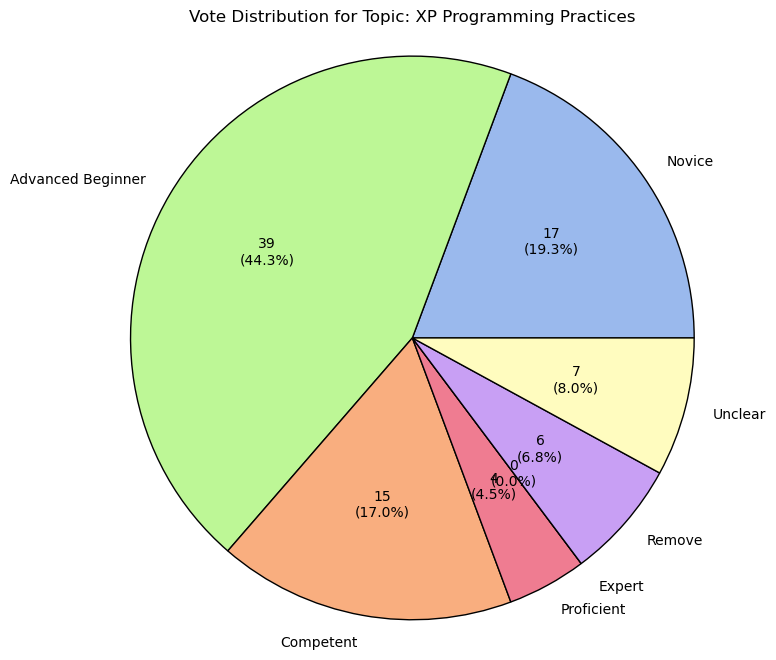

In [22]:
color_palette = ['#9ab9ed', '#bdf796', '#f9ae7f', '#ef7c91', '#a3a3ff', '#c89ff4', '#fffcbf']

# Custom function to show absolute values and percentages
def func(pct, allvals):
    absolute = int(pct / 100. * sum(allvals))  # Calculate the absolute number
    return f"{absolute}\n({pct:.1f}%)"  # Format as absolute value and percentage

# Sort the DataFrame by the 'index' column in alphabetical order
df_sorted = overview.sort_values(by="index")

for index, row in df_sorted.iterrows():
    plt.figure(figsize=(8,8))
    labels = ['Novice', 'Advanced Beginner', 'Competent', 'Proficient', 'Expert', 'Remove', 'Unclear']
    sizes = row[['Novice', 'Advanced Beginner', 'Competent', 'Proficient', 'Expert', 'Remove', 'Unclear']].values
    plt.pie(sizes, 
            labels=labels, 
            # autopct='%1.1f%%', 
            autopct=lambda pct: func(pct, sizes),  # Use the custom function
            colors=color_palette, 
            wedgeprops={'edgecolor': 'black'})
    plt.title(f'Vote Distribution for Topic: {row["index"]}')
    plt.axis('equal')
    plt.show()
